#### Follow tutorial
https://towardsdatascience.com/advanced-missing-data-imputation-methods-with-sklearn-d9875cbcc6eb

In [1]:
import pandas as pd
import numpy as np
from io import StringIO

In [2]:
materialData = pd.read_excel('ASHRAE_All.xlsx')
materialData

,No.,material category,description,density (lb/ft3),Unnamed: 4,"conductivity, k/λ (Btu in/(ft2 h °F))","resistance, R (h ft2 °F/Btu)",specific heat (Btu/(lb °F)),note,reference
0,1,"Insulating material: Blanket and batt c, d",Glass-fiber batts,NaN,NaN,NaN,NaN,0.2,[a],Kumaran (2002)
1,2,"Insulating material: Blanket and batt c, d",Glass-fiber batts,0.47 - 0.51,NaN,0.32 - 0.33,NaN,NaN,[a],Four manufacturers (2011)
2,3,"Insulating material: Blanket and batt c, d",Glass-fiber batts,0.61 - 0.75,NaN,0.28 - 0.30,NaN,NaN,[a],Four manufacturers (2011)
3,4,"Insulating material: Blanket and batt c, d",Glass-fiber batts,0.79 - 0.85,NaN,0.26 - 0.27,NaN,NaN,[a],Four manufacturers (2011)
4,5,"Insulating material: Blanket and batt c, d",Glass-fiber batts,1.4,NaN,0.23,NaN,NaN,[a],Four manufacturers (2011)
...,...,...,...,...,...,...,...,...,...,...
250,251,Woods (12% moisture content) l: Hardwoods,"West coast woods, cedars",22 - 31,NaN,0.68 - 0.90,NaN,NaN,[a],Cardenas and Bible (1987)
251,252,Woods (12% moisture content) l: Hardwoods,Eastern white cedar.,23,NaN,0.82 - 0.89,NaN,NaN,[a],Kumaran (2002)
252,253,Woods (12% moisture content) l: Hardwoods,California redwood,24 - 28,NaN,0.74 - 0.82,NaN,NaN,[a],Cardenas and Bible (1987)
253,254,Woods (12% moisture content) l: Hardwoods,Pine (oven-dried),23,NaN,0.64,NaN,0.45,[a],Kumaran (1996)


In [5]:
#MaterialCategory
materialCategory = materialData['material category']
materialDescription = materialData['description']

print(materialCategory.unique())
print(materialDescription.unique())
print(len(materialCategory.unique()))
print(len(materialDescription.unique()))


['Insulating material: Blanket and batt c, d'
 'Insulating material: Board and slabs' 'Insulating material: Loose fill'
 'Insulating material: Spray applied' 'Building Board and Siding: Board'
 'Building Board and Siding: Shingles' 'Building Board and Siding: Siding'
 'Building Membrane' 'Finish Flooring'
 'Metal roofing (See Chapter 33, Table 3)' 'Plastering Materials'
 'Masonry Materials: Masonry units' 'Masonry Materials: Concrete blocks h'
 'Masonry Materials: Concretes'
 'Woods (12% moisture content) l: Hardwoods'
 'Woods (12% moisture content) l: Softwoods']
['Glass-fiber batts' 'Rock and slag wool batts' 'Mineral wool, felted'
 'Cellular glass'
 'Cement fiber slabs, shredded wood with portland cement binder'
 'Cement fiber slabs, shredded wood with portland cement with magnesia oxysulfide binder'
 'Glass fiber board' 'Expanded rubber (rigid)'
 'Extruded polystyrene, smooth skin'
 'Extruded polystyrene, smooth skin aged per CAN/ULC Standard S770-2003.'
 'Extruded polystyrene, smo

In [4]:
#SPLIT Specific Heat Value

#Function to split float, when inside
def heat_split(name):
    if pd.isna(name): # Check for NaN values
        return pd.Series([np.nan, np.nan])
    name = str(name)  # Convert to string if not already
    if ' - ' in name:
        return pd.Series(name.split(' - ', 1))
    else:
        return pd.Series([name, name])

#Specific Heat (Btu/(lb °F))
heat_split = materialData['specific heat (Btu/(lb °F))'].apply(heat_split)

# Name the new columns appropriately, for example 'density_min' and 'density_max'
materialData['heat_min'] = heat_split[0]
materialData['heat_max'] = heat_split[1]

materialData['heat_min'] = pd.to_numeric(materialData['heat_min']) * 4.1868 * 1000
materialData['heat_max'] = pd.to_numeric(materialData['heat_max']) * 4.1868 * 1000
materialData['heat_median'] = (materialData['heat_min'] + materialData['heat_max']) / 2
materialHeat = materialData['heat_median']

#Convert from Specific Heat Capacity  (Btu/(lb °F)) to [J/kg.K]
#1 BTU/Pound °F (BTU/lb∙°F) = 4.1868 Kilojoule/Kilogram K (kJ/kg∙K) AND times 1000 to convert to J/kg∙K

print(len(materialHeat), materialHeat)

255 0       837.36
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
250        NaN
251        NaN
252        NaN
253    1884.06
254    1884.06
Name: heat_median, Length: 255, dtype: float64


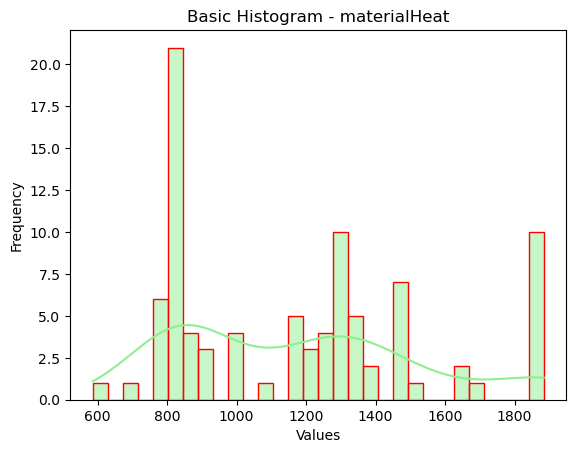

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Generate random data for the histogram
data = materialHeat
 
# Plotting a basic histogram
#plt.hist(data, bins=30, color='skyblue', edgecolor='black')
sns.histplot(data, bins=30, kde=True, color='lightgreen', edgecolor='red')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram - materialHeat')
 
# Display the plot
plt.show()

In [7]:
#SPLIT Density

#Function to split float, when inside
def density_split(name):
    if pd.isna(name):  # Check for NaN values
        return pd.Series([np.nan, np.nan])
    name = str(name)  # Convert to string if not already
    if ' - ' in name:
        return pd.Series(name.split(' - ', 1))
    else:
        return pd.Series([name, name])

#Density (lb/ft3) >>>
# Use str.split with expand=True to split the values and create two new columns
#density_split = materialData['density (lb/ft3)'].str.split(' - ', expand=True)
density_split = materialData['density (lb/ft3)'].apply(density_split)

# Name the new columns appropriately, for example 'density_min' and 'density_max'
materialData['density_min'] = density_split[0]
materialData['density_max'] = density_split[1]
# Convert the new columns to numeric
materialData['density_min'] = pd.to_numeric(materialData['density_min']) * 16.0184634
materialData['density_max'] = pd.to_numeric(materialData['density_max']) * 16.0184634
materialData['density_median'] = (materialData['density_min'] + materialData['density_max']) / 2
materialDensity = materialData['density_median']

print(materialDensity)
print(len(materialDensity))


0             NaN
1        7.849047
2       10.892555
3       13.135140
4       22.425849
          ...    
250    424.489280
251    368.424658
252    416.480048
253    368.424658
254    400.461585
Name: density_median, Length: 255, dtype: float64
255


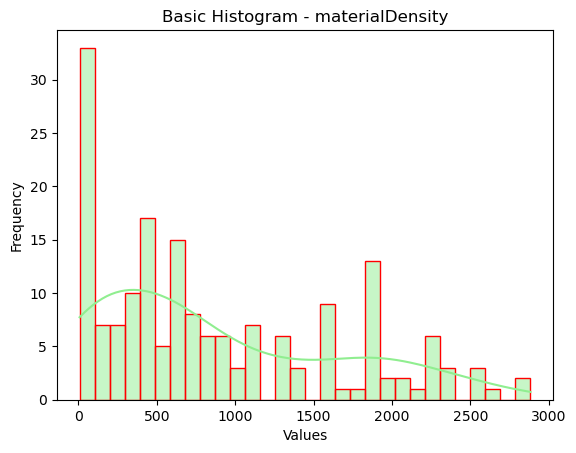

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Generate random data for the histogram
data = materialDensity
 
# Plotting a basic histogram
#plt.hist(data, bins=30, color='skyblue', edgecolor='black')
sns.histplot(data, bins=30, kde=True, color='lightgreen', edgecolor='red')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram - materialDensity')
 
# Display the plot
plt.show()

In [9]:
#SPLIT Conductivity, 

#Function to split float when - inside
def conductivity_split(name):
    if pd.isna(name):  # Check for NaN values
        return pd.Series([np.nan, np.nan])
    name = str(name)  # Convert to string if not already
    if ' - ' in name:
        return pd.Series(name.split(' - ', 1))
    else:
        return pd.Series([name, name])

conductivity_split = materialData['conductivity, k/λ (Btu in/(ft2 h °F))'].apply(conductivity_split)

#Name the new columns
materialData['conductivity_min'] = conductivity_split[0]
materialData['conductivity_max'] = conductivity_split[1]
# Convert the new columns to numeric
materialData['conductivity_min'] = pd.to_numeric(materialData['conductivity_min']) * 0.144
materialData['conductivity_max'] = pd.to_numeric(materialData['conductivity_max']) * 0.144
materialData['conductivity_median'] = (materialData['conductivity_min'] + materialData['conductivity_max']) / 2    
materialConductivity = materialData['conductivity_median']

print(materialConductivity)
print(len(materialConductivity))
#print(materialCategory, materialDescription, materialDensity, materialConductivity)

#print(materialCategory, materialDescription, materialDensity, materialData[['density (lb/ft3)', 'density_min', 'density_max', 'density_average', 'conductivity_min', 'conductivity_max', 'conductivity_average']])


0          NaN
1      0.04680
2      0.04176
3      0.03816
4      0.03312
        ...   
250    0.11376
251    0.12312
252    0.11232
253    0.09216
254    0.09936
Name: conductivity_median, Length: 255, dtype: float64
255


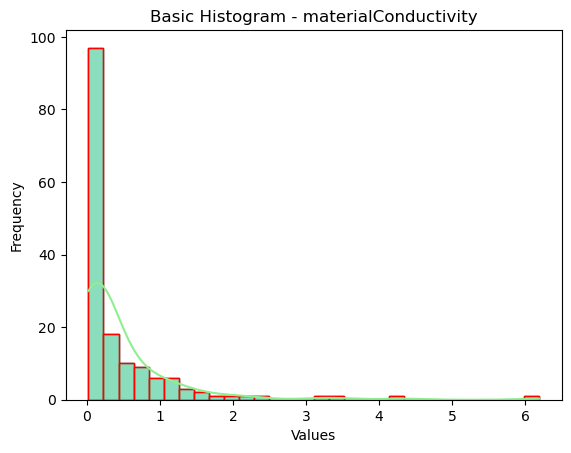

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Generate random data for the histogram
data = materialConductivity
 
# Plotting a basic histogram
plt.hist(data, bins=30, color='skyblue', edgecolor='black')
sns.histplot(data, bins=30, kde=True, color='lightgreen', edgecolor='red')


# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram - materialConductivity')
 
# Display the plot
plt.show()

In [11]:
materialData = pd.DataFrame({
#    'materialCategory': materialCategory,  # Use the actual variable
#    'materialDescription': materialDescription,  # Use the actual variable
    'materialDensity': materialDensity,  # Use the actual variable
    'materialConductivity': materialConductivity,  # Use the actual variable
    'materialHeatCapacity': materialHeat
})

In [12]:
print(materialData)

     materialDensity  materialConductivity  materialHeatCapacity
0                NaN                   NaN                837.36
1           7.849047               0.04680                   NaN
2          10.892555               0.04176                   NaN
3          13.135140               0.03816                   NaN
4          22.425849               0.03312                   NaN
..               ...                   ...                   ...
250       424.489280               0.11376                   NaN
251       368.424658               0.12312                   NaN
252       416.480048               0.11232                   NaN
253       368.424658               0.09216               1884.06
254       400.461585               0.09936               1884.06

[255 rows x 3 columns]


## Correlation Matrix

In [13]:
from scipy import stats
import seaborn as sns

In [14]:
ASHRAEcorr = materialData.corr()
round(ASHRAEcorr,2)

,materialDensity,materialConductivity,materialHeatCapacity
materialDensity,1.00,0.74,-0.43
materialConductivity,0.74,1.00,-0.41
materialHeatCapacity,-0.43,-0.41,1.00


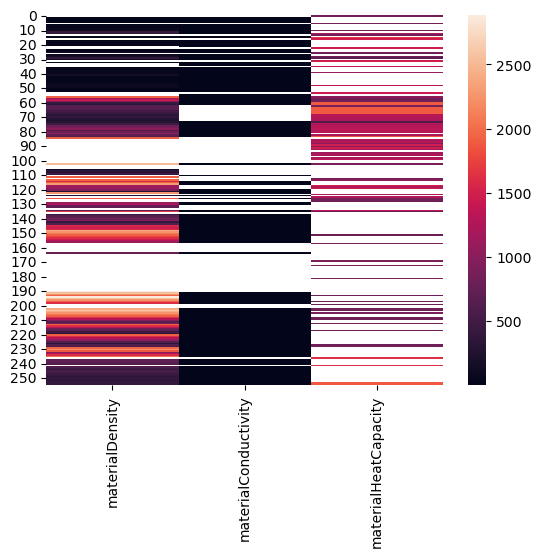

In [15]:
sns.heatmap(materialData.iloc[:]);

## Analyse type of missingness

In [9]:
!pip install missingno


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import missingno as msno

<Axes: >

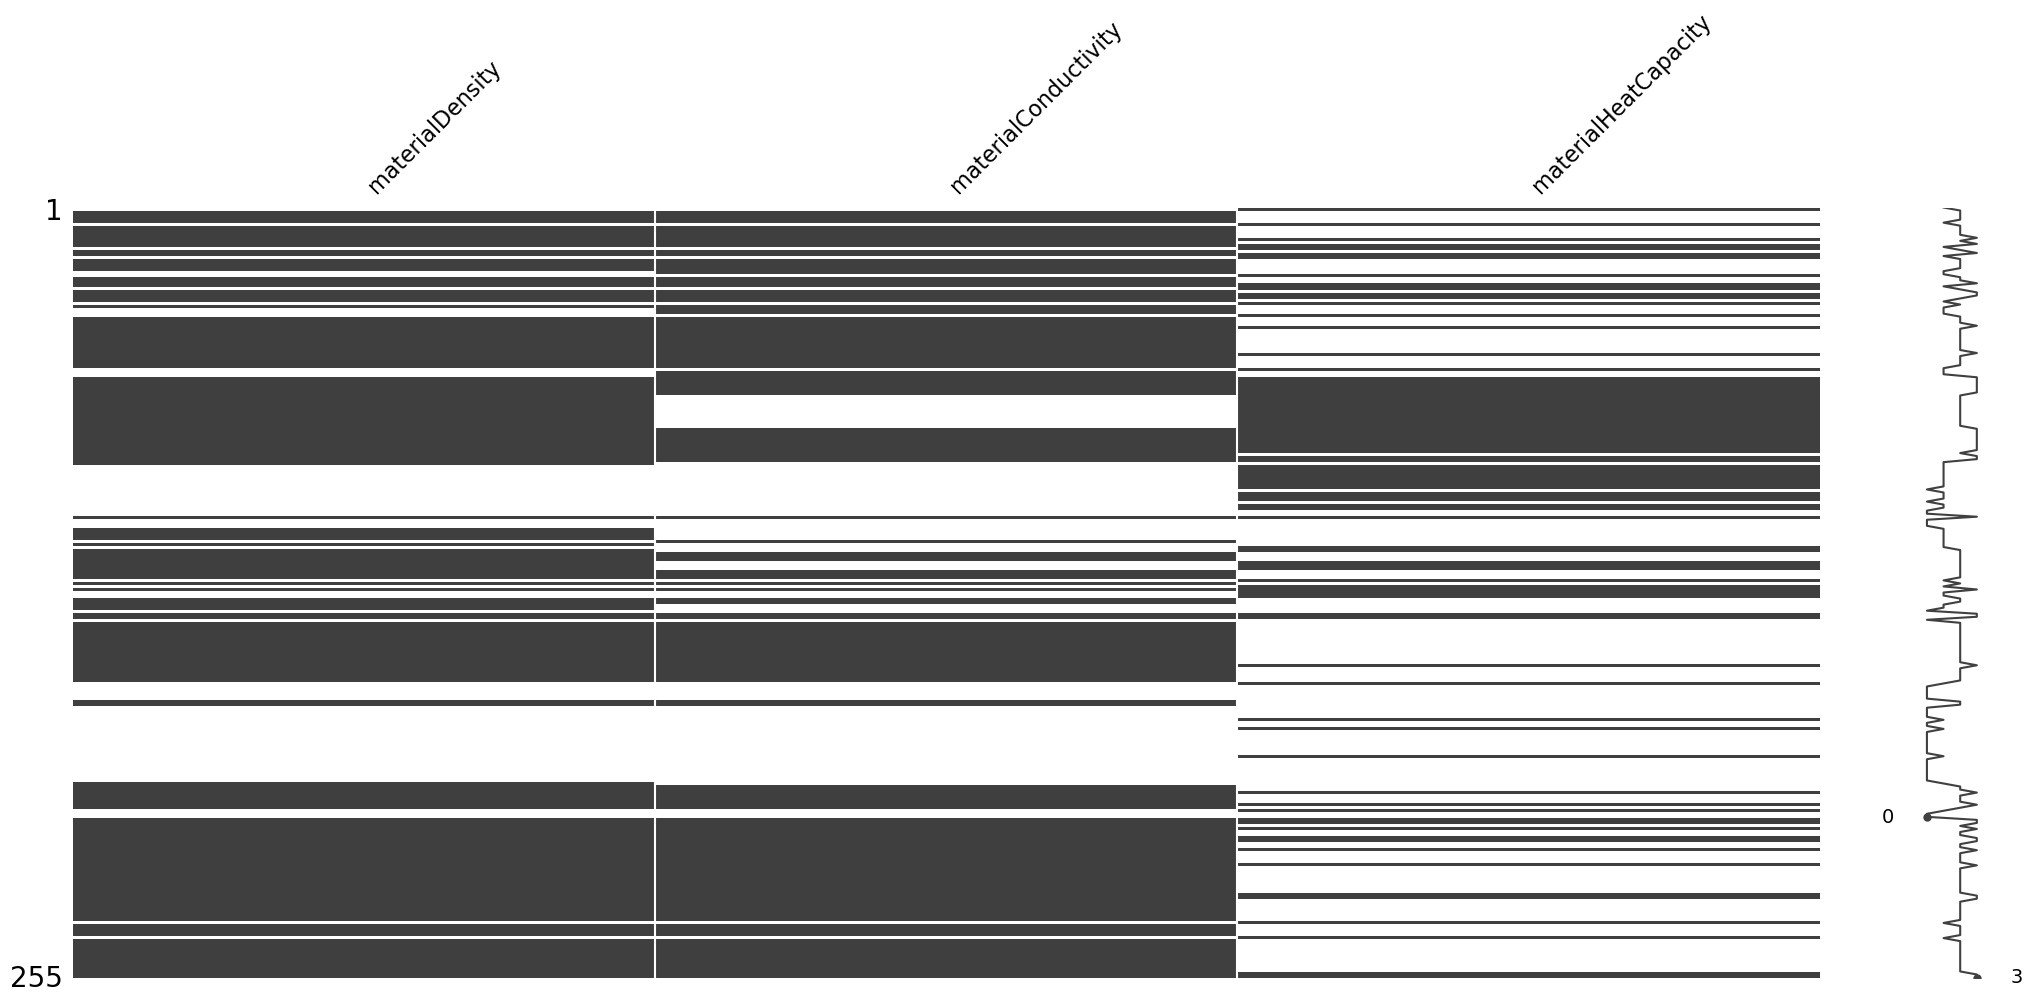

In [17]:
msno.matrix(materialData)
#This matrix shows how nulls are scattered across the dataset

<Axes: >

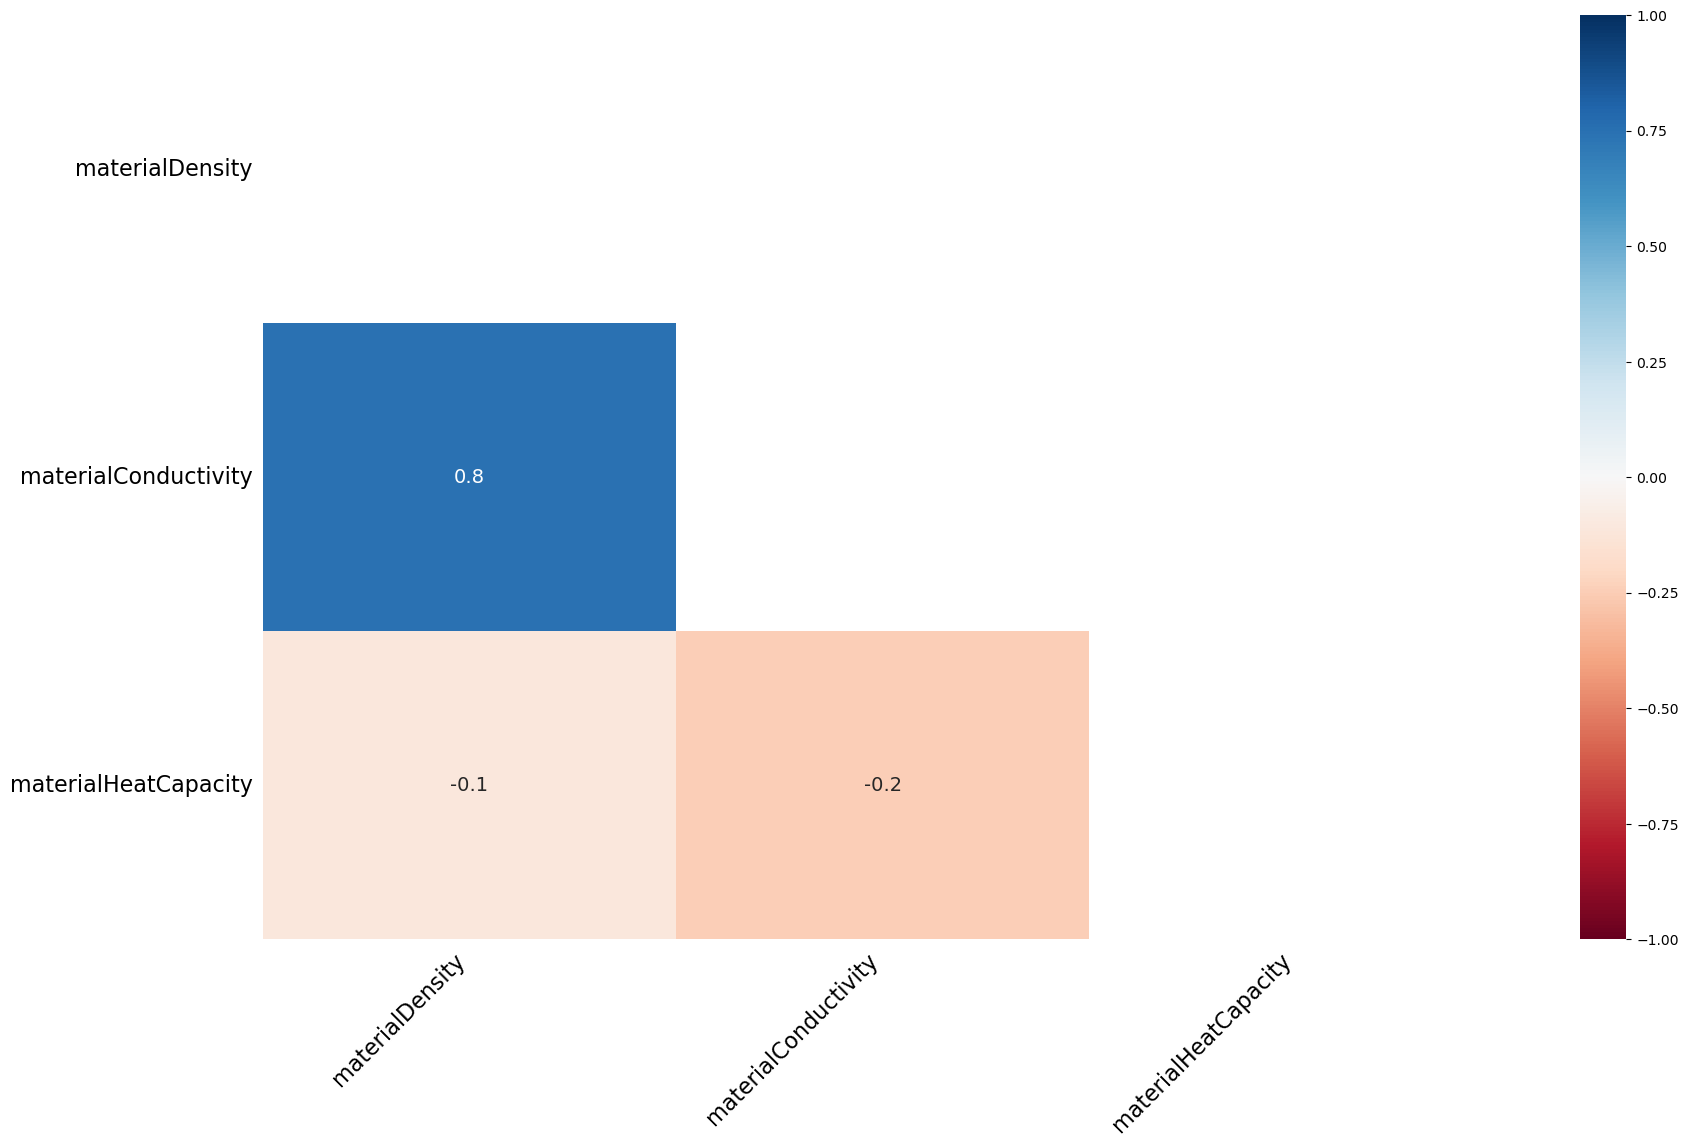

In [18]:
#Is there a relationship between the missingness inside the data?
msno.heatmap(materialData)

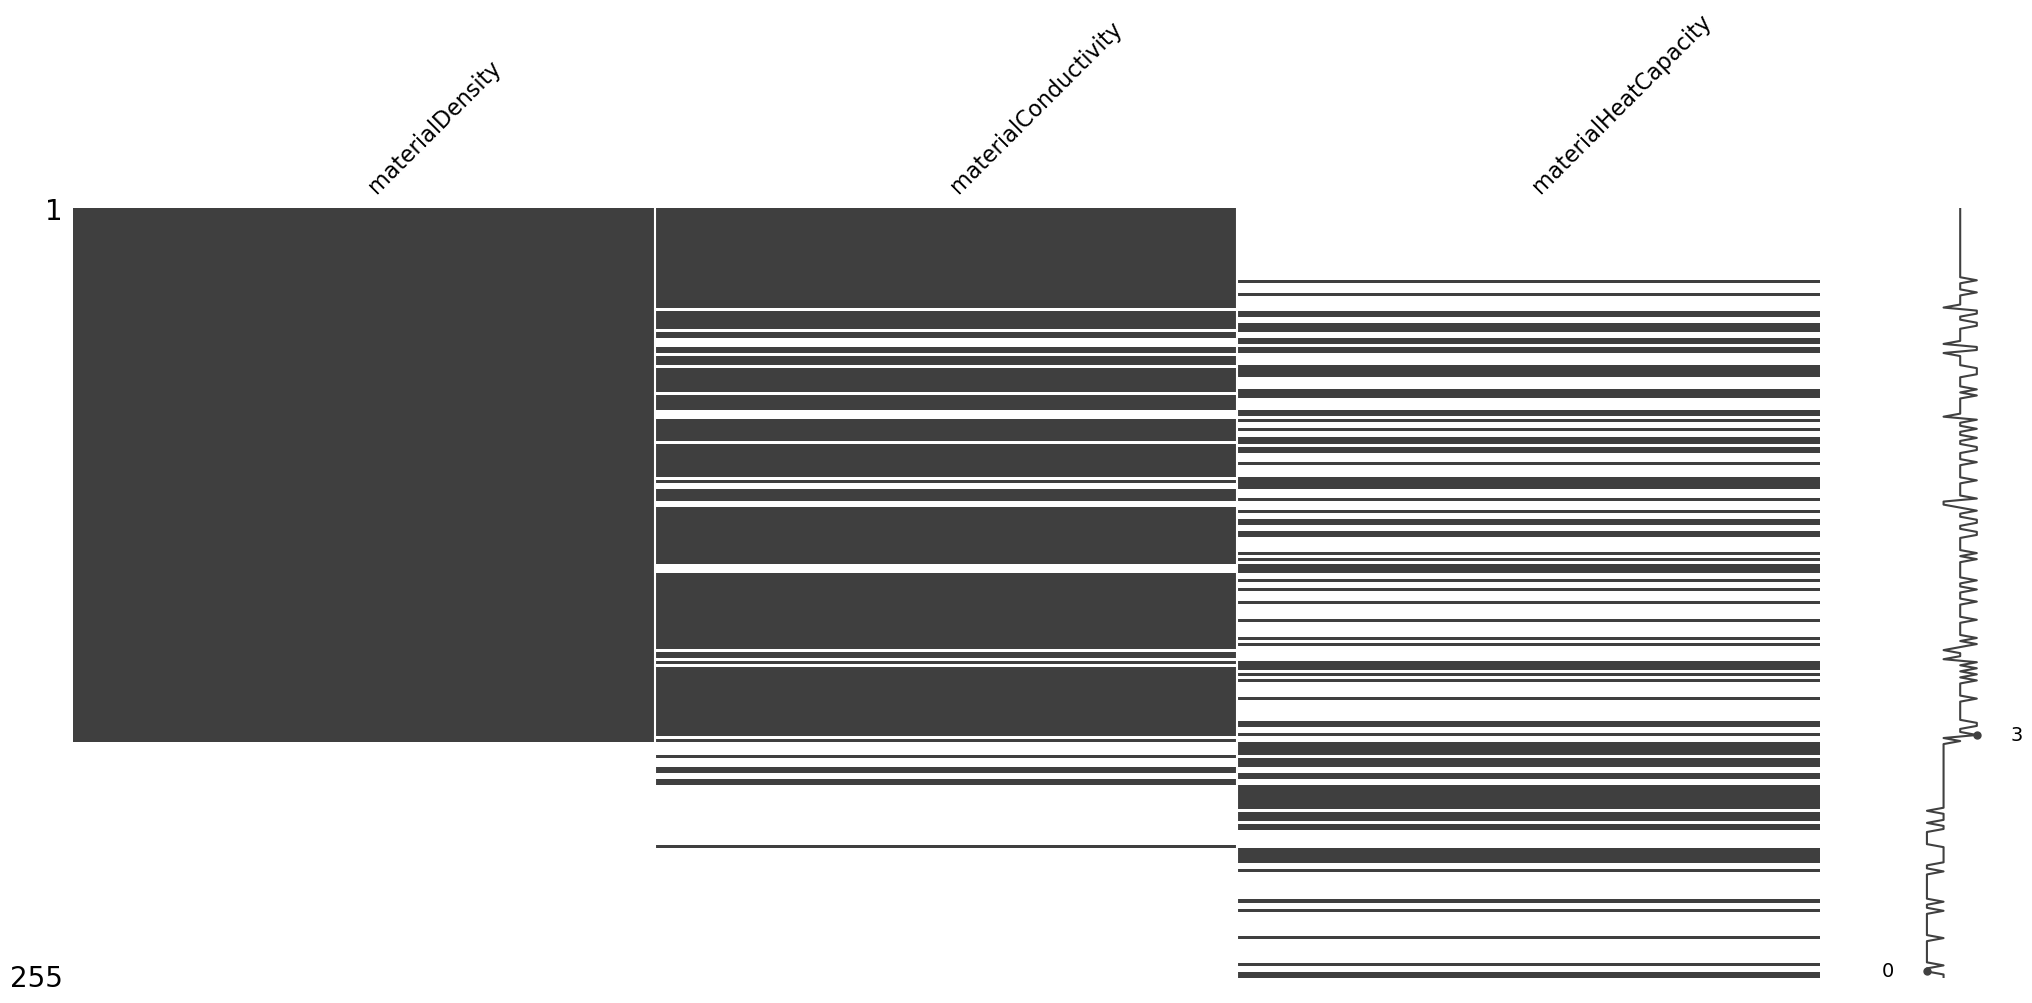

In [19]:
#We can see a strong correlation between material Density and materialConductivity from the plot. 
#We can confirm this by sorting either of the columns:
msno.matrix(materialData.sort_values("materialDensity"));

#The plot shows that if a data point is missing in materialDensity, 
#we can guess that it is somewhat related and also missing from materialConductivity and materialHeatCapacity
#there is weak correlation between density and capacity
#columns are not missing at random (MNAR)

## Impute Mean, Median, Mode

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

     materialDensity  materialConductivity  materialHeatCapacity
0         880.752133              0.455765            837.360000
1           7.849047              0.046800           1181.505758
2          10.892555              0.041760           1181.505758
3          13.135140              0.038160           1181.505758
4          22.425849              0.033120           1181.505758
..               ...                   ...                   ...
250       424.489280              0.113760           1181.505758
251       368.424658              0.123120           1181.505758
252       416.480048              0.112320           1181.505758
253       368.424658              0.092160           1884.060000
254       400.461585              0.099360           1884.060000

[255 rows x 3 columns]
     materialDensity  materialConductivity  materialHeatCapacity
0         640.738536               0.15840               837.360
1           7.849047               0.04680              1172.304
2

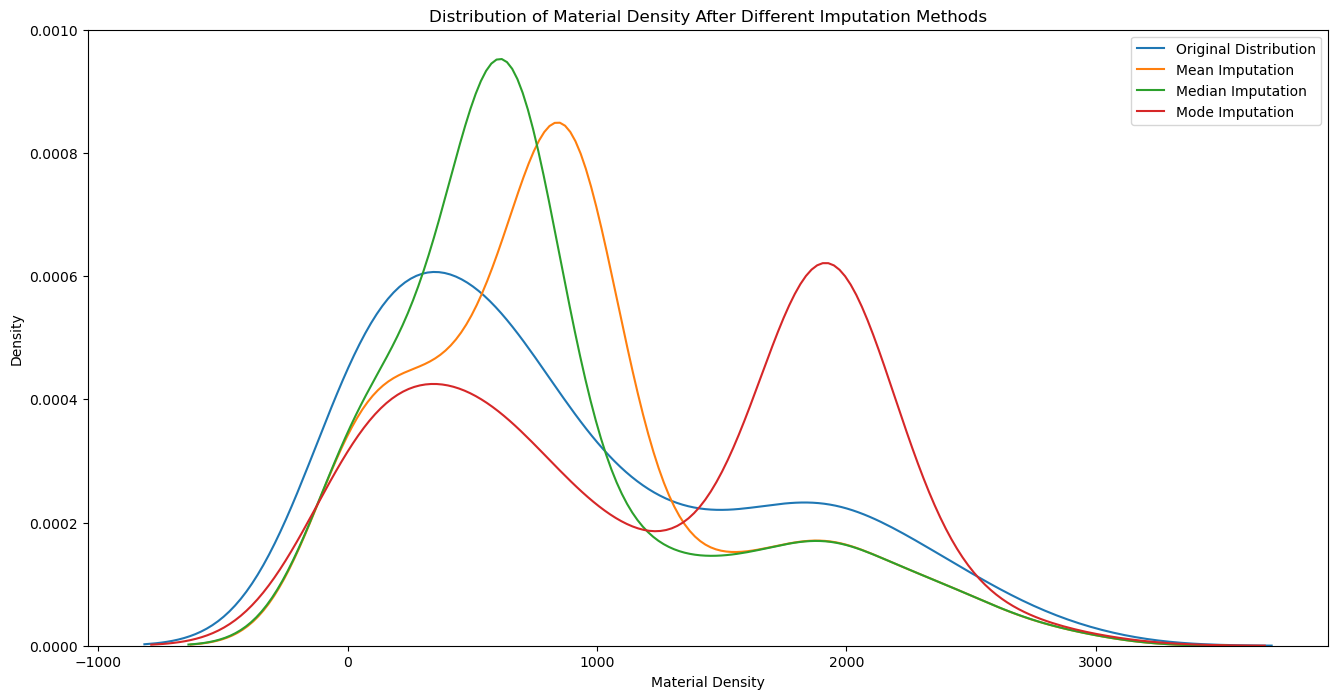

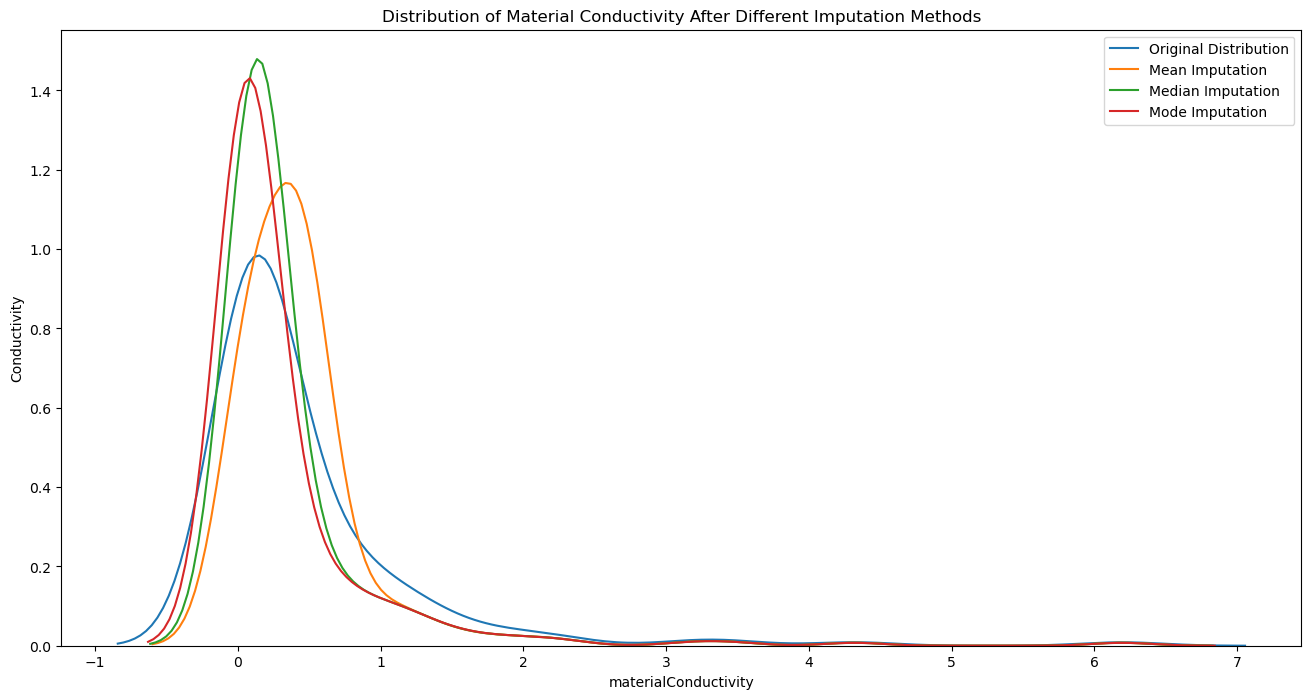

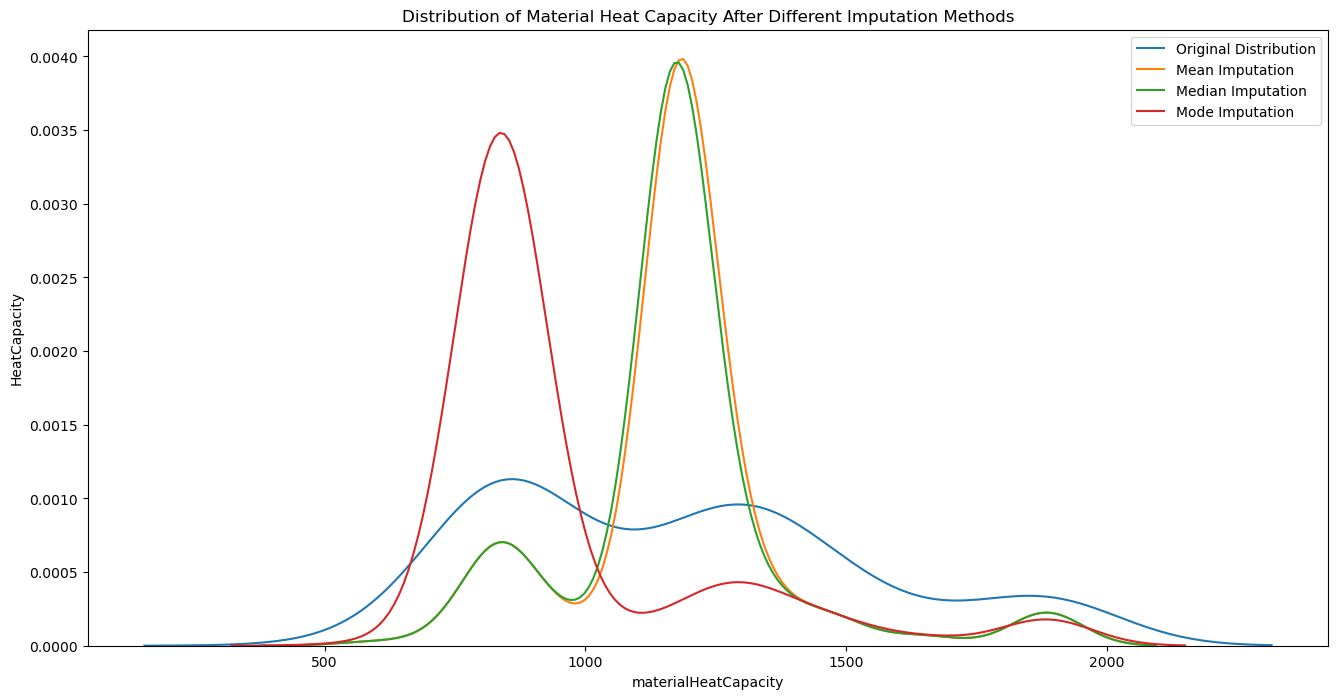

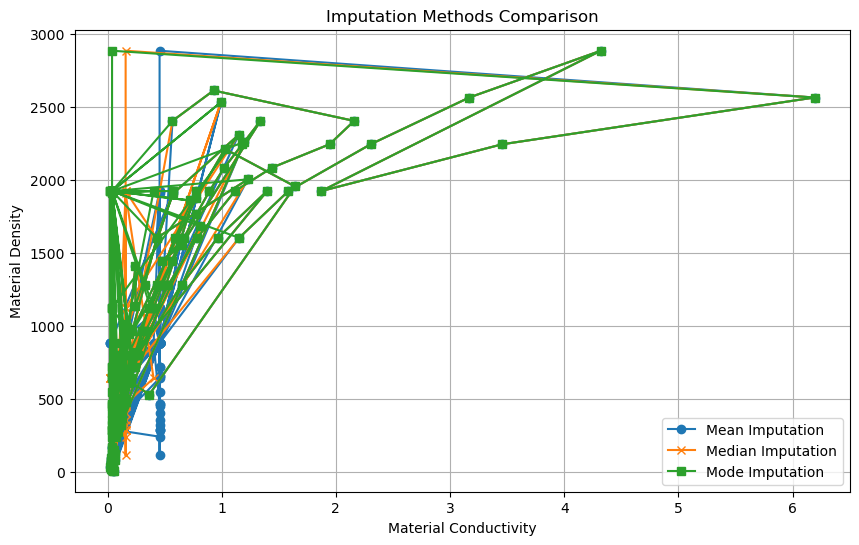

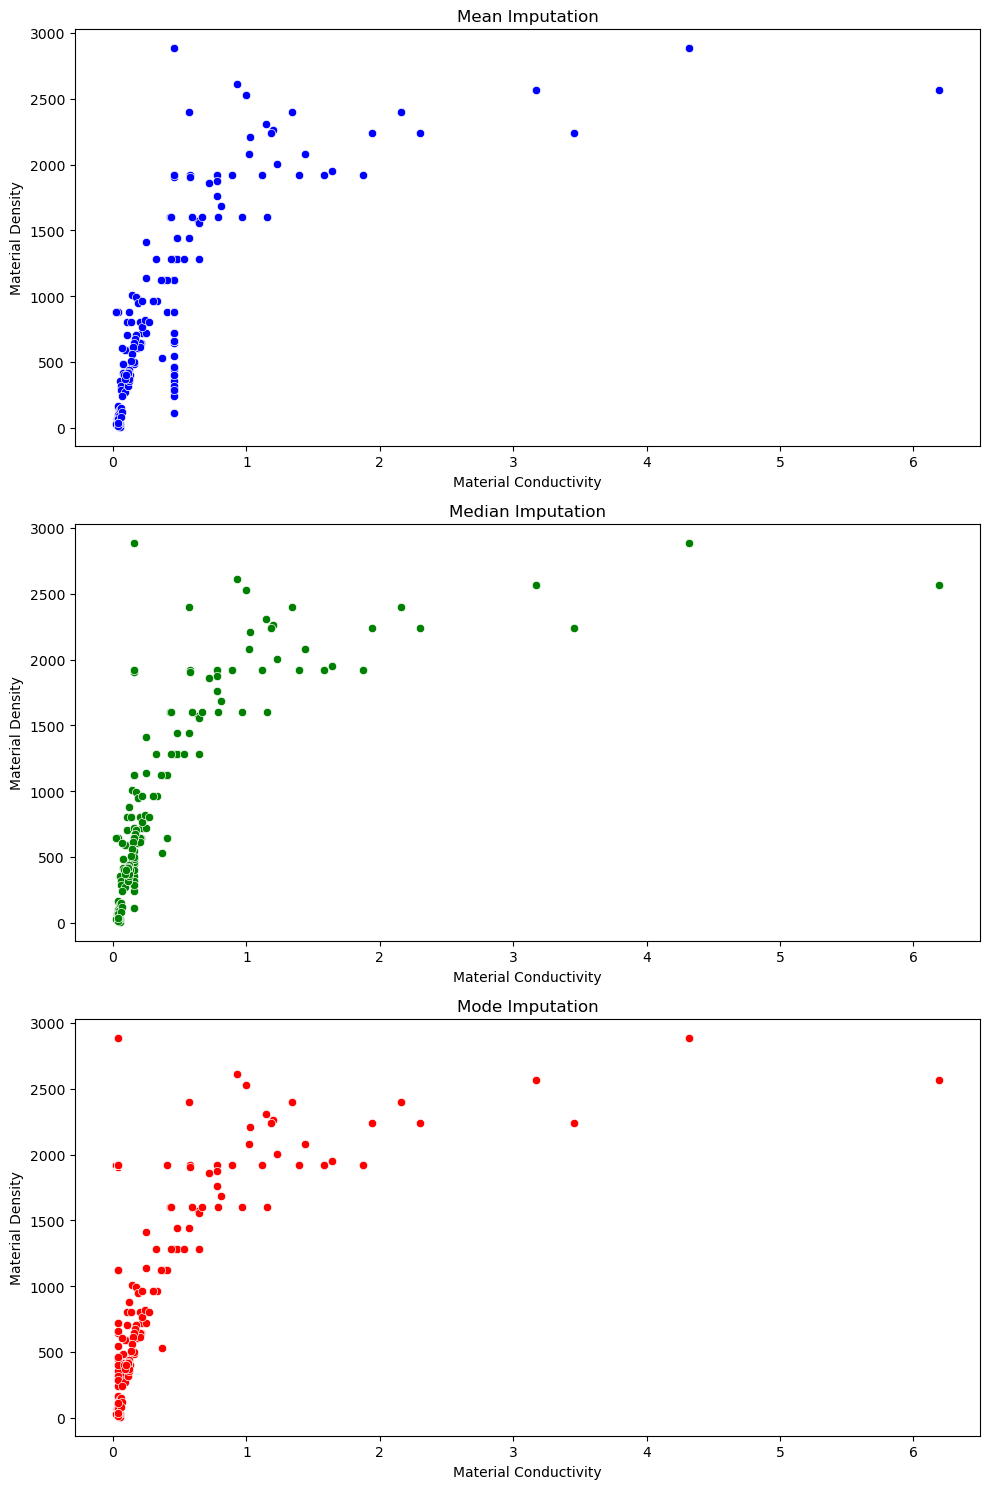

In [21]:
mean_imputation = materialData.fillna(materialData.mean()) 
median_imputation = materialData.fillna(materialData.median()) 
mode_imputation = materialData.fillna(materialData.mode().iloc[0])

print(mean_imputation)
print(median_imputation)
print(mode_imputation)

# Plotting---0
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the original distribution
sns.kdeplot(materialData['materialDensity'].dropna(), label="Original Distribution", ax=ax)

# Plot mean imputation
sns.kdeplot(mean_imputation['materialDensity'], label="Mean Imputation", ax=ax)

# Plot median imputation
sns.kdeplot(median_imputation['materialDensity'], label="Median Imputation", ax=ax)

# Plot mode imputation
sns.kdeplot(mode_imputation['materialDensity'], label="Mode Imputation", ax=ax)

# Add legend
plt.legend()

# Add titles and labels
plt.title('Distribution of Material Density After Different Imputation Methods')
plt.xlabel('Material Density')
plt.ylabel('Density')

# Show the plot
plt.show()



# Plotting---01
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the original distribution
sns.kdeplot(materialData['materialConductivity'].dropna(), label="Original Distribution", ax=ax)

# Plot mean imputation
sns.kdeplot(mean_imputation['materialConductivity'], label="Mean Imputation", ax=ax)

# Plot median imputation
sns.kdeplot(median_imputation['materialConductivity'], label="Median Imputation", ax=ax)

# Plot mode imputation
sns.kdeplot(mode_imputation['materialConductivity'], label="Mode Imputation", ax=ax)

# Add legend
plt.legend()

# Add titles and labels
plt.title('Distribution of Material Conductivity After Different Imputation Methods')
plt.xlabel('materialConductivity')
plt.ylabel('Conductivity')

# Show the plot
plt.show()



# Plotting---01
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the original distribution
sns.kdeplot(materialData['materialHeatCapacity'].dropna(), label="Original Distribution", ax=ax)

# Plot mean imputation
sns.kdeplot(mean_imputation['materialHeatCapacity'], label="Mean Imputation", ax=ax)

# Plot median imputation
sns.kdeplot(median_imputation['materialHeatCapacity'], label="Median Imputation", ax=ax)

# Plot mode imputation
sns.kdeplot(mode_imputation['materialHeatCapacity'], label="Mode Imputation", ax=ax)

# Add legend
plt.legend()

# Add titles and labels
plt.title('Distribution of Material Heat Capacity After Different Imputation Methods')
plt.xlabel('materialHeatCapacity')
plt.ylabel('HeatCapacity')

# Show the plot
plt.show()



#######OTHER PLOTS
#Plotting ---1
#initialise the figure
plt.figure(figsize=(10, 6))

# Plot mean imputation
plt.plot(mean_imputation['materialConductivity'], mean_imputation['materialDensity'], label='Mean Imputation', marker='o')

# Plot median imputation
plt.plot(median_imputation['materialConductivity'], median_imputation['materialDensity'], label='Median Imputation', marker='x')

# Plot mode imputation
plt.plot(mode_imputation['materialConductivity'], mode_imputation['materialDensity'], label='Mode Imputation', marker='s')

# Titles and labels
plt.title('Imputation Methods Comparison')
plt.xlabel('Material Conductivity')
plt.ylabel('Material Density')
plt.legend()
plt.grid(True)
plt.show()



# Plotting----2
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot mean imputation
sns.scatterplot(ax=axes[0], x='materialConductivity', y='materialDensity', data=mean_imputation, color='blue')
axes[0].set_title('Mean Imputation')
axes[0].set_xlabel('Material Conductivity')
axes[0].set_ylabel('Material Density')

# Plot median imputation
sns.scatterplot(ax=axes[1], x='materialConductivity', y='materialDensity', data=median_imputation, color='green')
axes[1].set_title('Median Imputation')
axes[1].set_xlabel('Material Conductivity')
axes[1].set_ylabel('Material Density')

# Plot mode imputation
sns.scatterplot(ax=axes[2], x='materialConductivity', y='materialDensity', data=mode_imputation, color='red')
axes[2].set_title('Mode Imputation')
axes[2].set_xlabel('Material Conductivity')
axes[2].set_ylabel('Material Density')

plt.tight_layout()
plt.show()

## Impute with KNN Imputer

#Sklearn uses K-Nearest-Neighbors (KNN) algorithm 
#KNN classification works depending on the value of k, the algorithm classifies new samples by the majority vote of the nearest k neighbors in classification. 
#KNN regressior, predicts the actual numerical value of a new sample, the algorithm takes the mean of the nearest k neighbors.”

#KNN Imputer is slightly modified version of the KNN algorithm. It tried to predict the value of numeric nullity by averaging the distances between its k nearest neighbors. 

In [104]:
from sklearn.impute import KNNImputer
import seaborn as sns

In [16]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
#Copy the data
materialData_knn_impute = materialData.copy(deep=True)

In [106]:
#Init the transformer 
knn_imp = KNNImputer(n_neighbors=3)

In [107]:
#Fit/transform
materialData_knn_impute.loc[:, :] = knn_imp.fit_transform(materialData_knn_impute)

In [108]:
materialData_knn_impute.isnull().sum()

materialDensity         0
materialConductivity    0
materialHeatCapacity    0
dtype: int64

It is difficult to find the correct value for K. so we take visual inspections

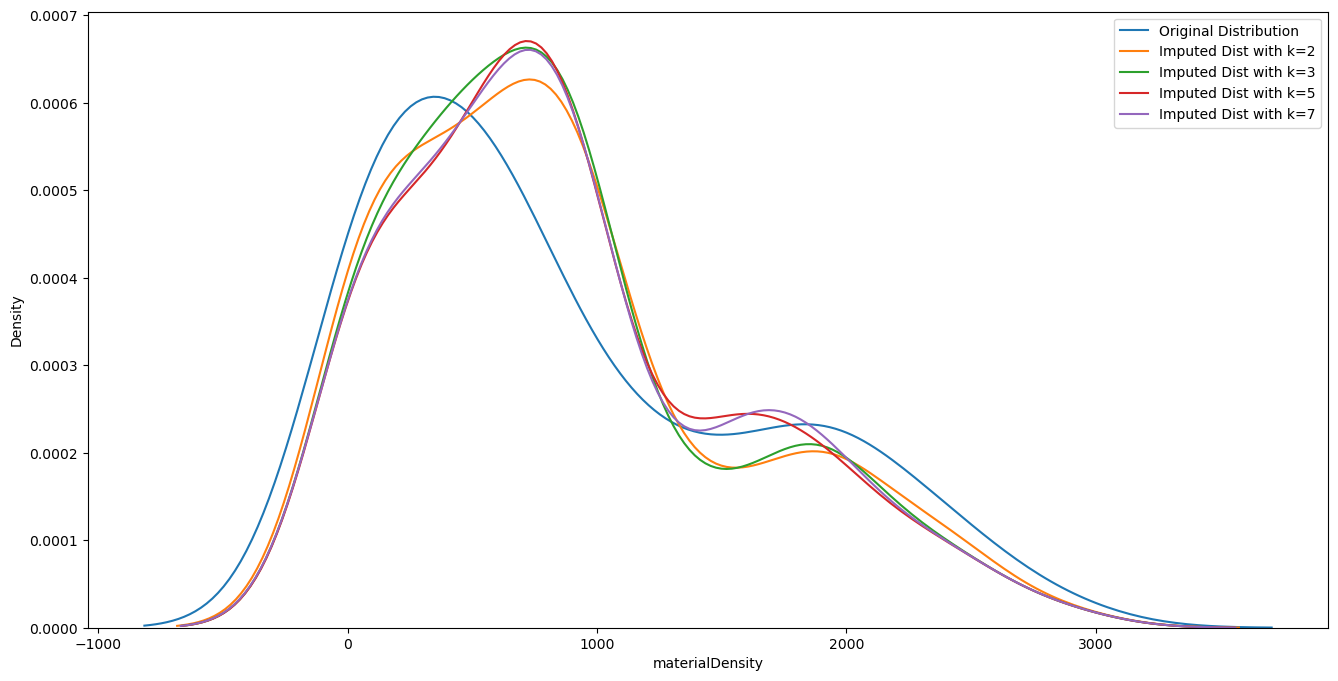

In [109]:
import matplotlib.pyplot as plt

n_neighbors = [2,3,5,7]
fig, ax = plt.subplots(figsize=(16, 8))\

# Plot the original distribution
sns.kdeplot(materialData.materialDensity, label="Original Distribution")

for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    materialData_knn_impute.loc[:, :] = knn_imp.fit_transform(materialData)
    sns.kdeplot( materialData_knn_impute.materialDensity, label=f"Imputed Dist with k={k}")

plt.legend();

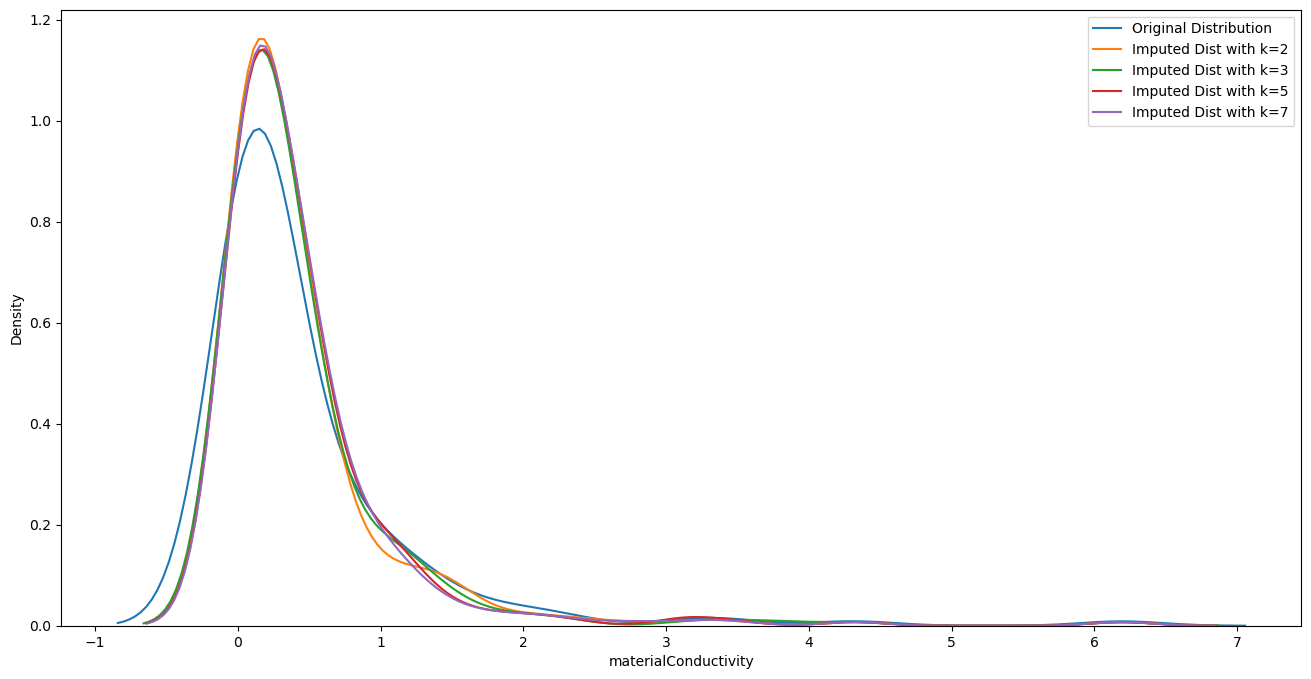

In [110]:
n_neighbors = [2,3,5,7]
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sns.kdeplot(materialData.materialConductivity, label="Original Distribution")

for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    materialData_knn_impute.loc[:, :] = knn_imp.fit_transform(materialData)
    sns.kdeplot(materialData_knn_impute.materialConductivity, label=f"Imputed Dist with k={k}")

plt.legend();

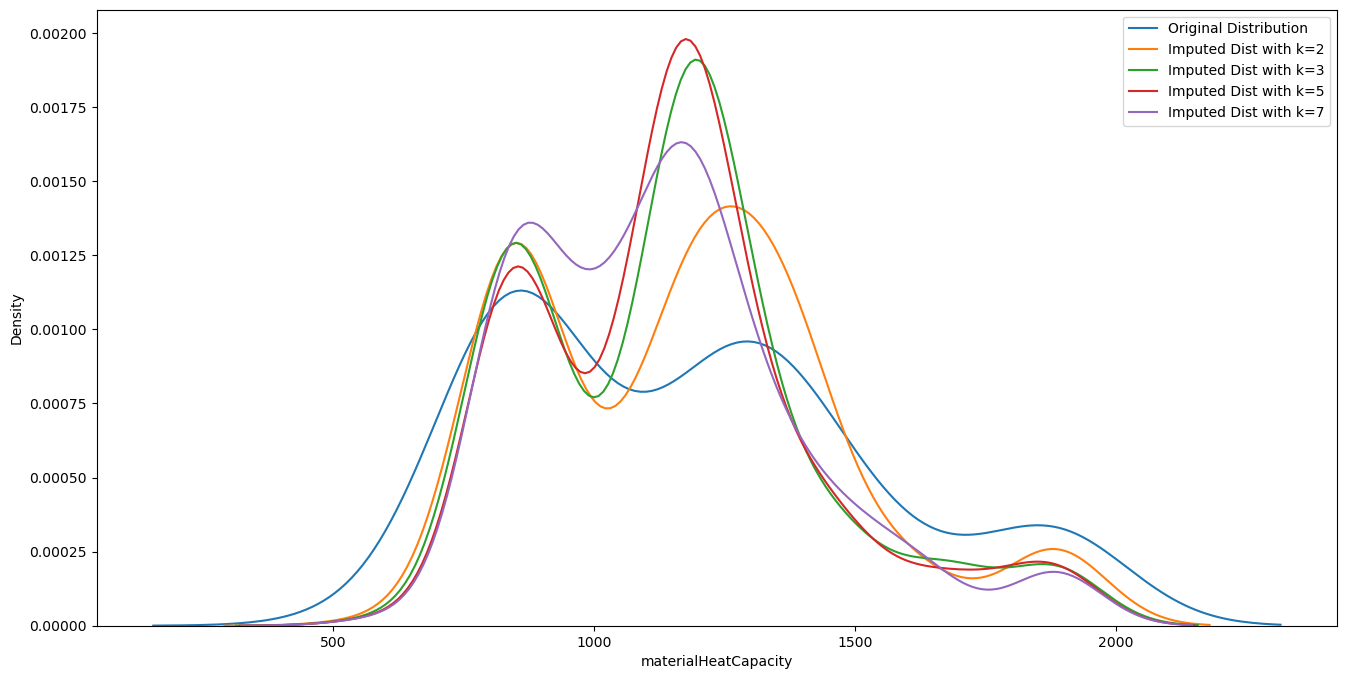

In [111]:
n_neighbors = [2,3,5,7]
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sns.kdeplot(materialData.materialHeatCapacity, label="Original Distribution")

for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    materialData_knn_impute.loc[:, :] = knn_imp.fit_transform(materialData)
    sns.kdeplot(materialData_knn_impute.materialHeatCapacity, label=f"Imputed Dist with k={k}")

plt.legend();

## Imputing With Iterative Imputer


1. A regressor is passed to the transformer.
2. The first feature (feature_1) with missing values is chosen.
3. The data is split into train/test sets where the train set contains all the known values for feature_1, and the test set contains the missing samples.
4. The regressor is fit on all the other variables as inputs and with feature_1 as an output.
5. The regressor predicts the missing values.
6. The transformer continues this process until all features are imputed.
7. Steps 1–6 are called a single iteration round, and these steps are carried out multiple times as specified by the max_iter transformer parameter.

In [22]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [23]:
#Copy the data
materialData_ii_imputed = materialData.copy(deep=True)

In [24]:
# Init, It models each feature with missing values as a function of other features in a round-robin fashion.
## ExtraTreesRegressor is used as the estimator. It is a machine learning model from the ensemble of decision trees.
## max_iter = 10 runs on max 10 iterations
## random_state=1121218: This sets the random seed for reproducibility. Initializing the random number generator in a way that ensures that the sequence of random numbers (or stochastic operations) generated will be the same each time the code is run. 

ii_imp = IterativeImputer(
    estimator=ExtraTreesRegressor(), max_iter=100, random_state=1121218
)

In [25]:
# Tranform
## [:, :]: This syntax selects all rows and all columns of the DataFrame.

materialData_ii_imputed.loc[:, :] = ii_imp.fit_transform(materialData_ii_imputed)

C:\Users\20180031\AppData\Local\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [26]:
materialData_ii_imputed.isnull().sum()

materialDensity         0
materialConductivity    0
materialHeatCapacity    0
dtype: int64

In [27]:
materialData_ii_imputed.describe()

,materialDensity,materialConductivity,materialHeatCapacity
count,255.000000,255.000000,255.000000
mean,842.481566,0.382924,1097.656640
std,669.698438,0.687247,297.844158
min,7.208309,0.021600,586.152000
25%,352.406195,0.082080,857.456640
50%,720.830853,0.201600,1004.832000
75%,1121.292438,0.297274,1297.908000
max,2883.323412,6.192000,1884.060000


In [28]:
print(materialData_ii_imputed)
#materialData_ii_imputed.to_excel("materialData_ii_imputed.xlsx", index=False)


     materialDensity  materialConductivity  materialHeatCapacity
0         616.710841               0.20160             837.36000
1           7.849047               0.04680            1016.34570
2          10.892555               0.04176            1088.56800
3          13.135140               0.03816            1123.73712
4          22.425849               0.03312            1353.17376
..               ...                   ...                   ...
250       424.489280               0.11376            1452.40092
251       368.424658               0.12312            1552.88412
252       416.480048               0.11232            1493.01288
253       368.424658               0.09216            1884.06000
254       400.461585               0.09936            1884.06000

[255 rows x 3 columns]


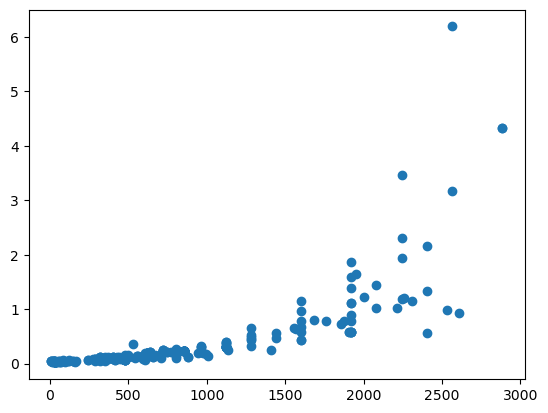

In [29]:
plt.scatter(materialData_ii_imputed.materialDensity, materialData_ii_imputed.materialConductivity)

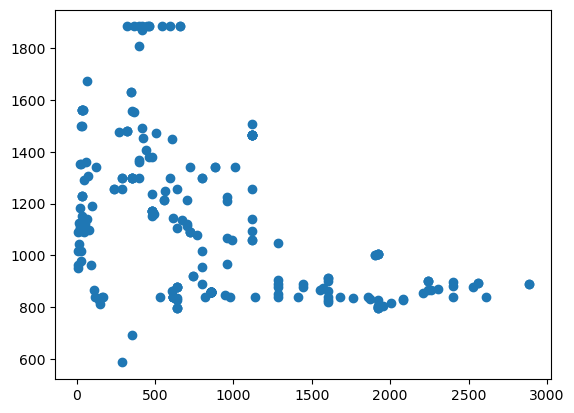

In [30]:
plt.scatter(materialData_ii_imputed.materialDensity, materialData_ii_imputed.materialHeatCapacity)

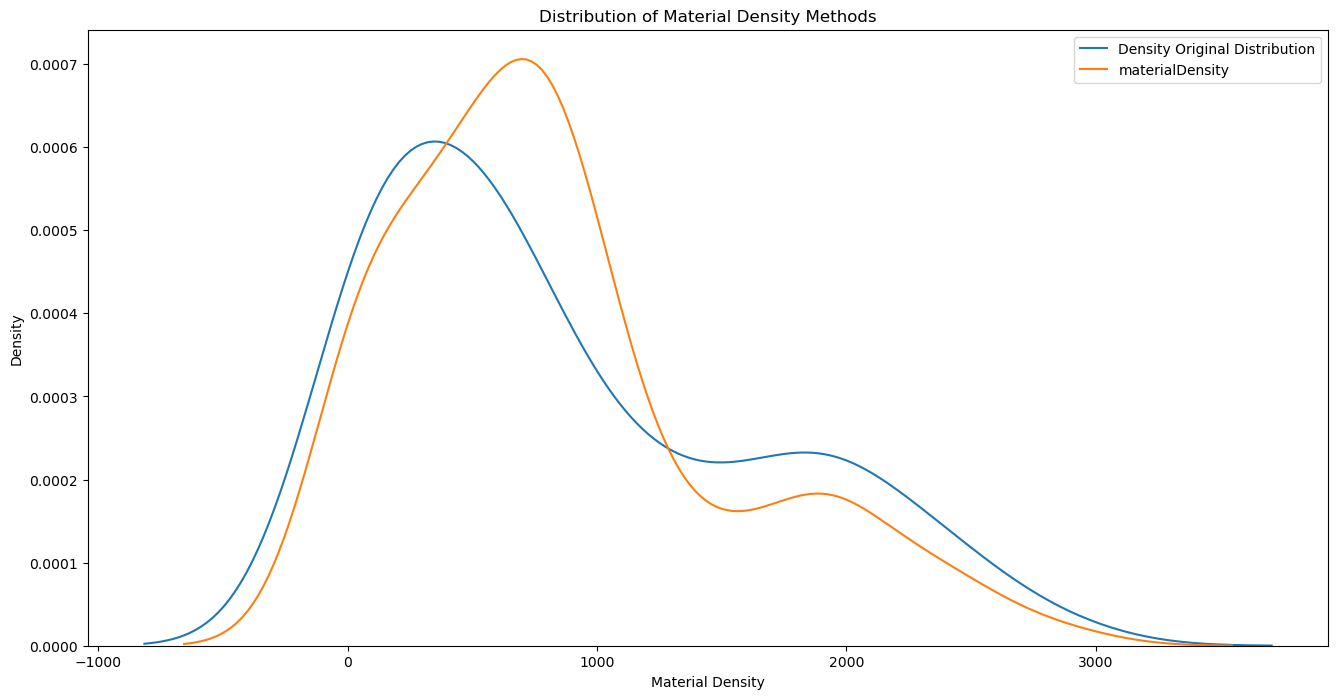

In [31]:
# Plotting---Denisty
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the original distribution
sns.kdeplot(materialData['materialDensity'].dropna(), label="Density Original Distribution", ax=ax)
# Plot iterative imputation density
sns.kdeplot(materialData_ii_imputed.materialDensity, label="materialDensity", ax=ax)

# Add legend
plt.legend()

# Add titles and labels
plt.title('Distribution of Material Density Methods')
plt.xlabel('Material Density')
plt.ylabel('Density')

# Show the plot
plt.show()

In [32]:
materialData['materialDensity'].describe()

count     177.000000
mean      880.752133
std       772.080539
min         7.208309
25%       288.332341
50%       640.738536
75%      1441.661706
max      2883.323412
Name: materialDensity, dtype: float64

In [33]:
materialData_ii_imputed.materialDensity.describe()

count     255.000000
mean      842.481566
std       669.698438
min         7.208309
25%       352.406195
50%       720.830853
75%      1121.292438
max      2883.323412
Name: materialDensity, dtype: float64

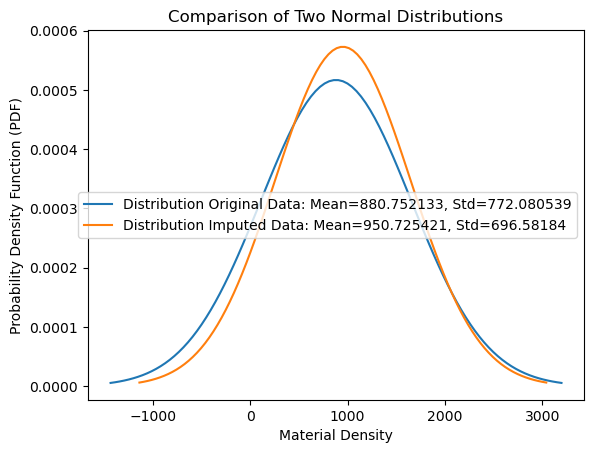

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Provided summary statistics for the first distribution
mean1 = 880.752133
std1 = 772.080539

# Provided summary statistics for the second distribution
#mean2 = 779.434558
mean2 = 950.725421

#std2 = 689.819031
std2 =  696.581840
# Generate x-values for the range covering both distributions
x1 = np.linspace(mean1 - 3*std1, mean1 + 3*std1, 100)
x2 = np.linspace(mean2 - 3*std2, mean2 + 3*std2, 100)

# Calculate the PDF for both distributions
pdf1 = stats.norm.pdf(x1, mean1, std1)
pdf2 = stats.norm.pdf(x2, mean2, std2)

# Plot both distributions
plt.plot(x1, pdf1, label=f'Distribution Original Data: Mean={mean1}, Std={std1}')
plt.plot(x2, pdf2, label=f'Distribution Imputed Data: Mean={mean2}, Std={std2}')

# Adding titles and labels
plt.title('Comparison of Two Normal Distributions')
plt.xlabel('Material Density')
plt.ylabel('Probability Density Function (PDF)')
plt.legend()

# Display the plot
plt.show()

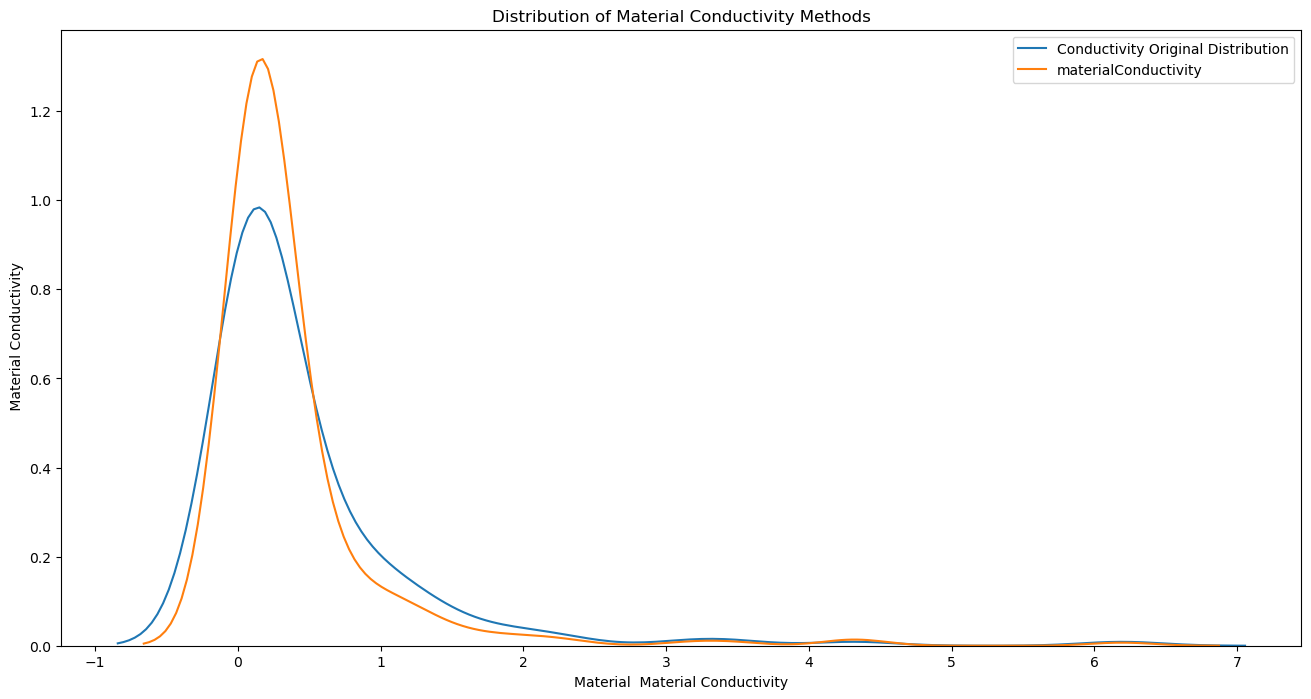

In [35]:
# Plotting---Conductivity
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the original distribution
sns.kdeplot(materialData['materialConductivity'].dropna(), label="Conductivity Original Distribution", ax=ax)
# Plot mean imputation
sns.kdeplot(materialData_ii_imputed.materialConductivity, label="materialConductivity", ax=ax)

# Add legend
plt.legend()

# Add titles and labels
plt.title('Distribution of Material Conductivity Methods')
plt.xlabel('Material  Material Conductivity')
plt.ylabel(' Material Conductivity')

# Show the plot
plt.show()



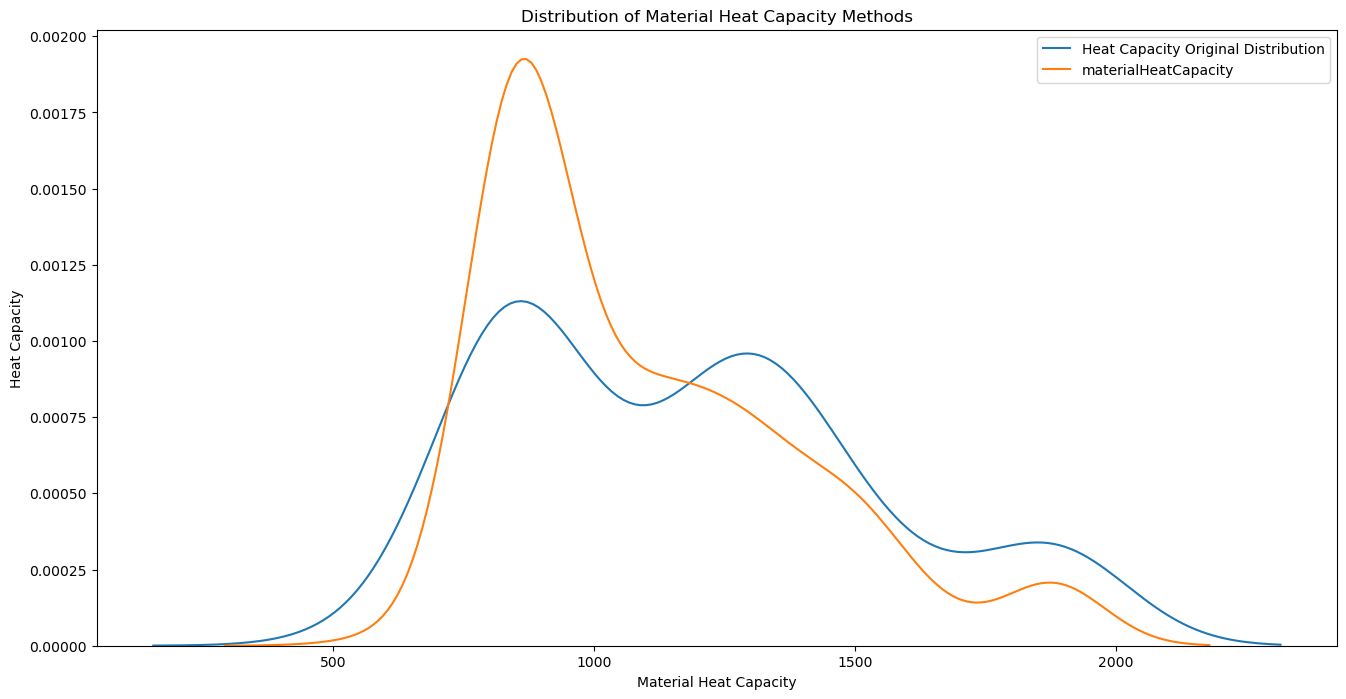

In [36]:
# Plotting---Heat Capacity
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the original distribution
sns.kdeplot(materialData['materialHeatCapacity'].dropna(), label="Heat Capacity Original Distribution", ax=ax)
# Plot mean imputation
sns.kdeplot(materialData_ii_imputed.materialHeatCapacity, label="materialHeatCapacity", ax=ax)


# Add legend
plt.legend()

# Add titles and labels
plt.title('Distribution of Material Heat Capacity Methods')
plt.xlabel('Material Heat Capacity')
plt.ylabel('Heat Capacity')

# Show the plot
plt.show()



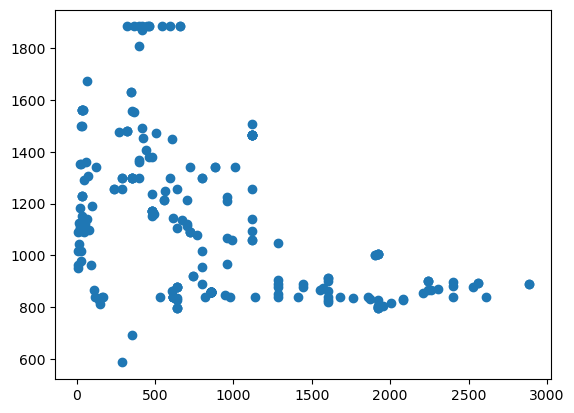

In [37]:
plt.scatter(materialData_ii_imputed.materialDensity, materialData_ii_imputed.materialHeatCapacity)

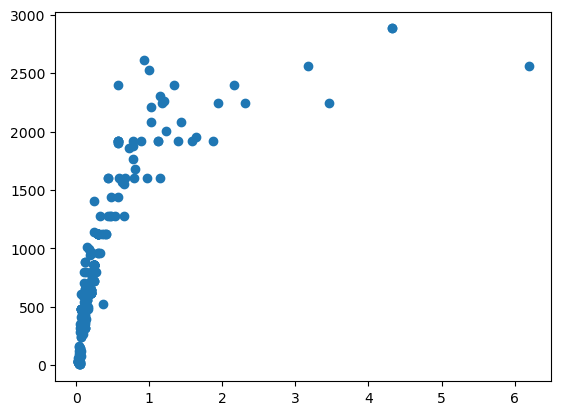

In [38]:
plt.scatter(materialData_ii_imputed.materialConductivity, materialData_ii_imputed.materialDensity)

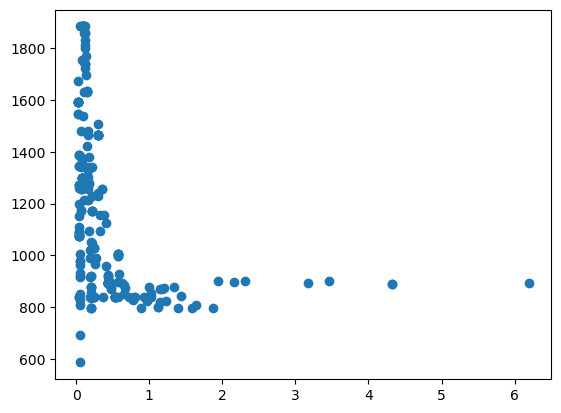

In [132]:
plt.scatter(materialData_ii_imputed.materialConductivity, materialData_ii_imputed.materialHeatCapacity)

## Correlation matrix

In [133]:
from scipy import stats
import seaborn as sns

In [39]:
stats.pearsonr(materialData_ii_imputed['materialDensity'], materialData_ii_imputed['materialConductivity'])

PearsonRResult(statistic=0.7407272723222534, pvalue=1.3230615682723305e-45)

In [40]:
ASHRAEcorr = materialData_ii_imputed.corr()
round(ASHRAEcorr,2)

,materialDensity,materialConductivity,materialHeatCapacity
materialDensity,1.00,0.74,-0.44
materialConductivity,0.74,1.00,-0.30
materialHeatCapacity,-0.44,-0.30,1.00


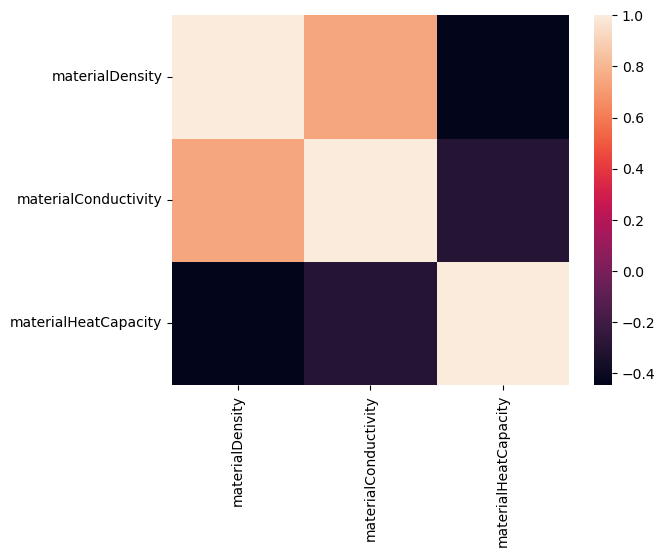

In [41]:
sns.heatmap(ASHRAEcorr);

## Benchmark Methods

IterativeImputer by Sklearn: https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html
BayesianRidge and ExtraTreeRegressor yield the best results.

Predict materialDensity based on materialConductivity and materialHeatCapacity, 
suit regression involve imputing missing values in dataset, training regression models, and evaluating their performance using cross-validation.

1. Prepare Your Data:
Separate your features (materialConductivity and materialHeatCapacity) and the target (materialDensity).
2. Set Up Imputation and Regression:
Use imputation methods like IterativeImputer and KNNImputer.
Use regression models like BayesianRidge and ExtraTreesRegressor.
3. Evaluate with Cross-Validation:
Use cross-validation to evaluate the performance of the models.

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [138]:
#drop missing data
materialData = materialData.dropna(subset=['materialDensity'])

# Feature/target arrays
#X_full contains all the features except for materialDensity. This is done by dropping the materialDensity column from materialData.
#y_full contains the target variable, which is the materialDensity column.
#.reshape(-1, 1) reshapes y_full to be a 2D array with one column, as many scikit-learn functions expect the target variable to be in this format.

X_full = materialData.drop("materialDensity", axis=1).copy()
y_full = materialData["materialDensity"].values.reshape(-1, 1)

# Set global configs
#cv = coefficient of variation = standard deviation/mean per variable
#state = 1121218: This sets the random seed for reproducibility. By using a fixed random state, you ensure that the results are consistent across different runs of the code.
cv = 3
scoring = "neg_mean_squared_error"  # Use MSE for regression, Mean Squared Error (MSE) is the statistical measure used to evaluate the quality of a model by quantifying the difference between actual and predicted values.
state = 1121218

In [139]:
# Store IterativeImputer scores
ii_scores = pd.DataFrame()
for estimator in [BayesianRidge(), ExtraTreesRegressor()]:
    pipe = make_pipeline(
        IterativeImputer(estimator=estimator, random_state=state), estimator
    )
    ii_scores[estimator.__class__.__name__] = cross_val_score(
        pipe, X_full, y_full.ravel(), scoring=scoring, cv=cv
    )

C:\Users\20180031\AppData\Local\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\20180031\AppData\Local\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\20180031\AppData\Local\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [140]:
# Store KNN scores using bayesian ridge as regresion method.
knn_scores = pd.DataFrame()
n_neighbors = [2, 3, 5, 7, 9]
for k in n_neighbors:
    pipe = make_pipeline(KNNImputer(n_neighbors=k), BayesianRidge())
    knn_scores[f"KNN(k = {k})"] = cross_val_score(
        pipe, X_full, y_full.ravel(), scoring=scoring, cv=cv
    )

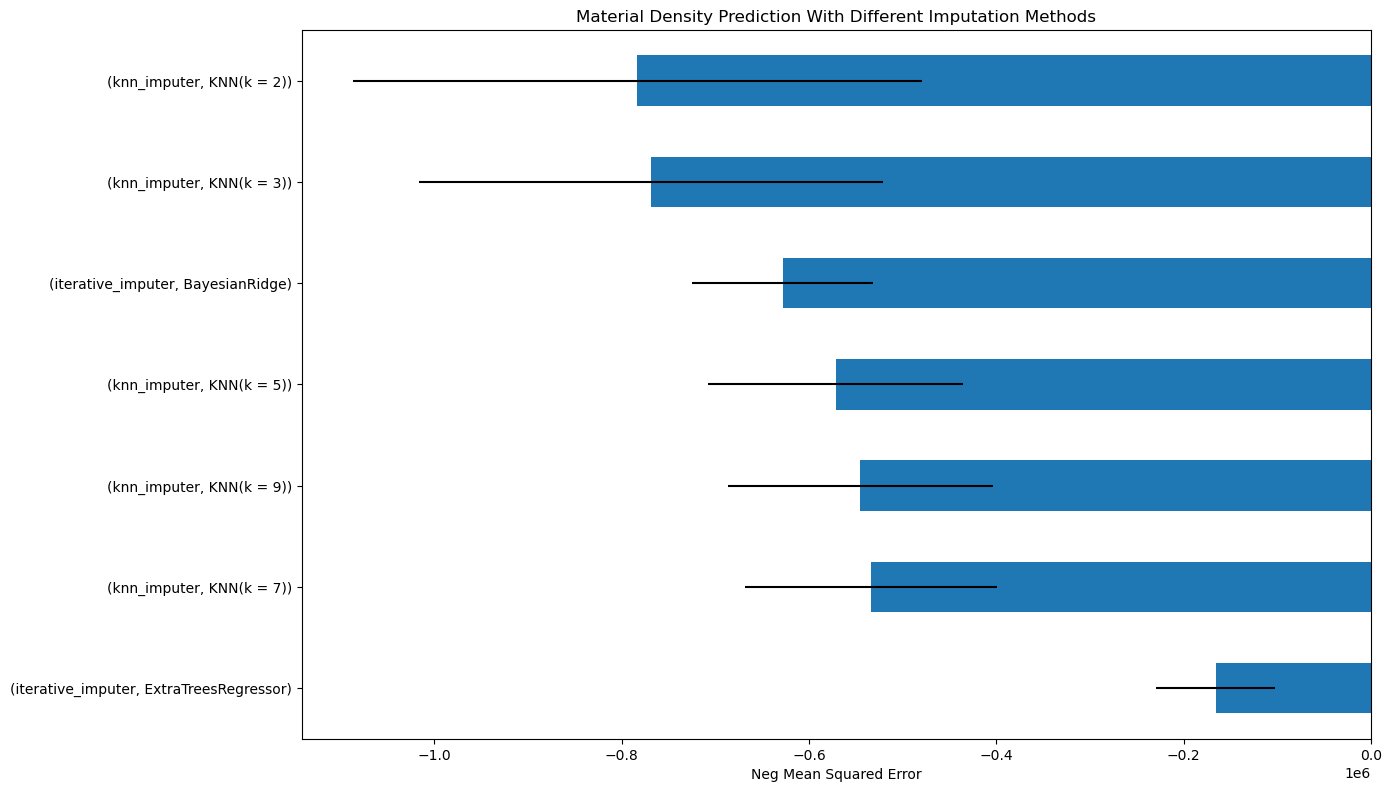

In [141]:
# Combine scores into a single DF
final_scores = pd.concat(
    [ii_scores, knn_scores],
    axis=1,
    keys=["iterative_imputer", "knn_imputer"],
)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

means, errors = final_scores.mean().sort_values(ascending=False), final_scores.std()
means.plot.barh(xerr=errors, ax=ax)

ax.set_title("Material Density Prediction With Different Imputation Methods")
ax.set_xlabel("Neg Mean Squared Error")
ax.set_yticks(np.arange(means.shape[0]))

plt.tight_layout(pad=1)
plt.show()

Summary from Imputations

Summary from Imputations

Summary from Imputations

Summary from Imputations

Summary from Imputations

Summary from Imputations

## Regression_Prediciton model, Data_IterativeImputation 

In [54]:
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import ShuffleSplit

Axes(0.125,0.11;0.775x0.77)


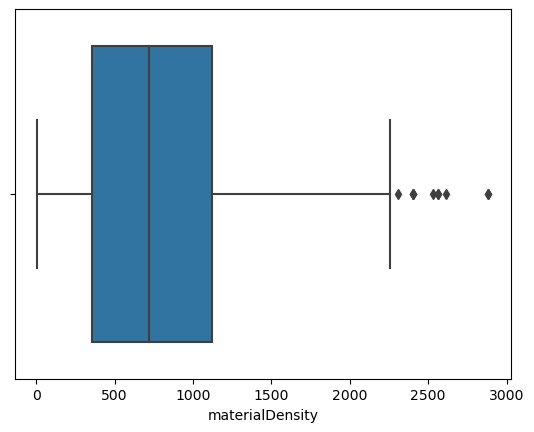

In [55]:
#Make a boxplot fir materialData_ii_imputet
print(sns.boxplot(x=materialData_ii_imputed["materialDensity"]))

Axes(0.125,0.11;0.775x0.77)


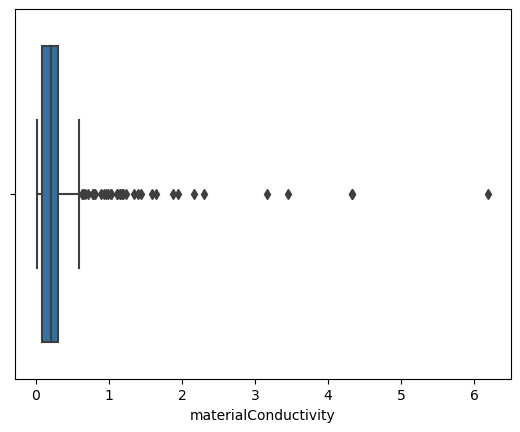

In [56]:
print(sns.boxplot(x=materialData_ii_imputed["materialConductivity"]))

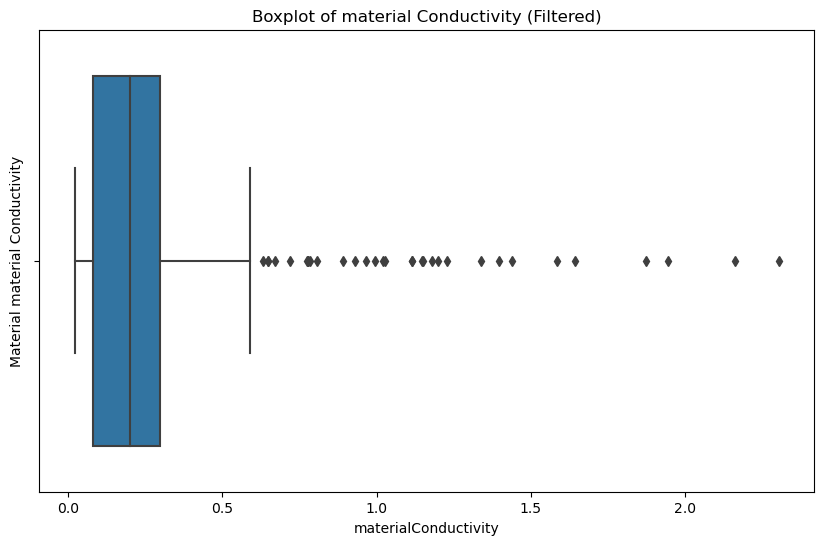

In [57]:
#remove outliers
filtered_data = materialData_ii_imputed[
    (materialData_ii_imputed.materialConductivity >= 0) & 
    (materialData_ii_imputed.materialConductivity <= 3)
]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_data.materialConductivity)
plt.title('Boxplot of material Conductivity (Filtered)')
plt.ylabel('Material material Conductivity')
plt.show()

In [58]:
print(filtered_data.materialConductivity)

0      0.20160
1      0.04680
2      0.04176
3      0.03816
4      0.03312
        ...   
250    0.11376
251    0.12312
252    0.11232
253    0.09216
254    0.09936
Name: materialConductivity, Length: 250, dtype: float64


In [59]:
print(materialConductivity)

0          NaN
1      0.04680
2      0.04176
3      0.03816
4      0.03312
        ...   
250    0.11376
251    0.12312
252    0.11232
253    0.09216
254    0.09936
Name: conductivity_median, Length: 255, dtype: float64


Axes(0.125,0.11;0.775x0.77)


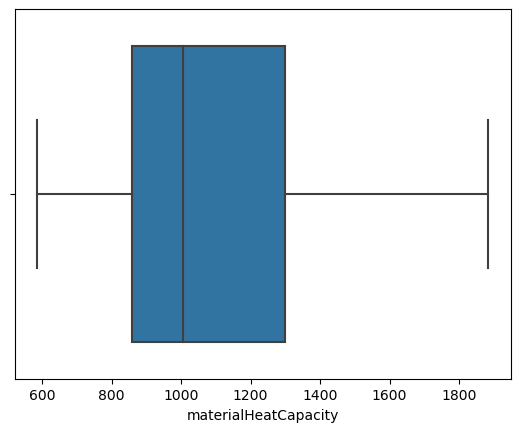

In [60]:
print(sns.boxplot(x=materialData_ii_imputed["materialHeatCapacity"]))

## Split and Shuffel Data

In [61]:
#Define dependent and independent variables
##reshape(-1,1) reshapes the column to 1D, 2D array
Y = np.array(materialData_ii_imputed.materialDensity).reshape(-1,1)
X = np.array(materialData_ii_imputed[['materialConductivity','materialHeatCapacity']])
            
#X2 = np.array(materialData_ii_imputed.materialConductivity).reshape(-1,1)

### Shuffel Split Validation

Shuffle Split is a Random permutation cross-validator.

The method allows to assess the model's performance across different splits of the data, 
which can provide a more robust evaluation of the model.
n_splits=5: Number of re-shuffling & splitting iterations.
test_size=0.25: Proportion of the dataset to include in the test split (25%).
random_state=0: Seed used by the random number generator to ensure reproducibility.

In [62]:
#Create a ShuffleSplit object:
rs = ShuffleSplit(n_splits=7, test_size=.25, random_state=0)

#Print the ShuffleSplit object:
rs.get_n_splits(X)
rs.get_n_splits(Y)

#Generate and print train/test indices for each split:
#multiple feature matrices (e.g., X1,X2,X3), combine to a single feature matrix before splitting the data into training and testing sets. 
for i, (train_index, test_index) in enumerate(rs.split(X, Y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    
    Y_train, Y_test = Y[train_index], Y[test_index]
    X_train, X_test = X[train_index], X[test_index]
    
    print(f"  X_train: \n{X_train}")
    print(f"  X_test: \n{X_test}")
    print(f"  Y_train: {Y_train}")
    print(f"  Y_test: {Y_test}")

Fold 0:
  Train: index=[184 248  33 108 156 228 245 214  92  16  96  75 107 176   4 116  61 124
  52  66  26 233 154 226  40  13   3 106  24  30 227  60  56 139 122  19
 190 136  54 204  80  51   2 219 104 134  86  10 144 181 237  41  14  27
  50 235  20 180  46 173 250 123 212 178  62 210 166 130 155 137  43 199
 146 161 112 206  98 160  93 201 243 113   0  94  95  69  49  48  85 252
 141  23 224 143  78 100 131 205 253   6  68  84 121 238 218 240 246 194
  91 217 232  11 119 102  35  57 169  65   1 120 203  42 105 132 220  17
  38 133  53 164 249 128  34  28 183 114 163 151 202  31 209 127 185 225
 236  32 167 142 213 147  29 177  99  82 251 175  79 197 208 115 148 247
  72  77  25 165  81 239 174 244  39 230 193  58 140  88 216  70  87  36
 242  21 211   9 103 195  67 192 117  47 172]
  Test:  index=[158  83 170 101 150 200 118 229  63 135 149 234 109 189 153  73 207 171
 157  97 188  45 241 138 110 254   8  55 221  37 196 126 111 198 168 145
 187   5  22 191 125  12 186 179  90 129

In [63]:
from sklearn.linear_model import LinearRegression 
model = LinearRegression()

In [64]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(model, X, Y, cv=rs, scoring='r2')

In [69]:
import numpy as np 

average_r2 = np.mean(scores) 

print(f"R² Score for each fold: {[round(score, 4) for score in scores]}")
print(f"Average R² across {i} folds: {average_r2:.2f}")

R² Score for each fold: [0.3659, 0.6129, 0.6329, 0.5022, 0.6462, 0.643, 0.6186]
Average R² across 6 folds: 0.57


In [71]:
#print(materialData_ii_imputed.columns)

### K-Fold Cross Validation 

This code initializes K-Fold Cross-Validation using the KFold class from sklearn.model_selection. We set up the instance kf with 5 splits. 

In K-Fold Cross-Validation, ‘K’ represents the number of groups into which the dataset is divided. This number determines how many rounds of testing the model undergoes, ensuring each segment is used as a testing set once. 
K= 2 or 3: These choices can be beneficial when computational resources are limited or when a quicker evaluation is needed. 
K= 5 or 10: Choosing K = 5 or K = 10 are popular choices because they provide a good balance between computational efficiency and model performance estimation. 
K = 20: Using a larger value of K can provide a more detailed performance evaluation.

The shuffle=True option randomizes the order of the data points, and the random_state=42 ensures that this shuffling is consistent across multiple runs. This setup is typically sufficient to start evaluating the performance of a model with cross-validation.  


In [98]:
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

#Print the ShuffleSplit object:
kf.get_n_splits(X)
kf.get_n_splits(Y)

#Generate and print train/test indices for each split:
#multiple feature matrices (e.g., X1,X2,X3), combine to a single feature matrix before splitting the data into training and testing sets. 
for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
    print(f"Fold {k}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    
    Y_train, Y_test = Y[train_index], Y[test_index]
    X_train, X_test = X[train_index], X[test_index]
    
    print(f"  X_train: \n{X_train}")
    print(f"  X_test: \n{X_test}")
    print(f"  Y_train: {Y_train}")
    print(f"  Y_test: {Y_test}")

Fold 0:
  Train: index=[  0   1   2   3   4   5   7   8  11  12  13  14  17  20  21  22  23  26
  27  28  29  31  32  34  35  36  37  38  39  40  41  42  43  44  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  69  70  71  72  73  74  76  77  78  80  81  82  83  84  85  87  88  89
  90  91  92  93  94  95  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 118 119 121 122 123 125 126 127 128 129 130
 131 132 133 134 135 138 139 140 141 142 143 144 145 146 147 149 150 151
 153 154 155 156 157 158 159 160 161 162 163 165 166 168 169 170 171 172
 173 174 175 178 179 182 183 186 187 188 189 191 192 193 194 196 197 199
 202 203 204 207 208 210 211 212 213 214 215 217 218 219 220 223 224 225
 226 227 228 230 231 232 233 235 236 237 239 240 241 242 244 245 246 247
 248 249 250 251 253 254]
  Test:  index=[  6   9  10  15  16  18  19  24  25  30  33  45  66  67  68  75  79  86
  96  97 117 120 124 136 137 148 152 164 167 176 177 180 181

With the data prepared and cross-validation set up, the next step is to choose and initialize the model. The LinearRegression class from sklearn.linear_model is used and create an instance model. This model will be used to perform linear regression on the dataset. 

In [99]:
from sklearn.linear_model import LinearRegression 
model = LinearRegression()

Now that the model is initialized, we can move on to the fun part and perform cross-validation to evaluate its performance on different subsets of the data.
This line uses the cross_val_score function to evaluate the model using the dataset X and target y. The cross-validation is conducted using the Kfold instance kf, and the model’s performance is measured using the R² score. 

In [100]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(model, X, Y, cv=kf, scoring='r2')

We can use R-squared as a metric to evaluate the proportion of variance in the dependent variable that is predictable from the independent variables, providing insight into the goodness of fit of the regression model. This part calculates the average R² score for all folds. The scores for each fold are printed first, followed by the average score. The use of np.mean() computes the mean of the scores collected during the cross-validation. 

In [101]:
import numpy as np 

average_r2 = np.mean(scores) 

print(f"R² Score for each fold: {[round(score, 4) for score in scores]}")
print(f"Average R² across {k} folds: {average_r2:.2f}")

R² Score for each fold: [0.7649, 0.4998, 0.7197, 0.6268, 0.4129]
Average R² across 5 folds: 0.60


Difference in **KFold and ShuffleSplit output**

KFold will divide your data set into prespecified number of folds, and every sample must be in one and only one fold. A fold is a subset of your dataset.

ShuffleSplit will randomly sample your entire dataset during each iteration to generate a training set and a test set. The test_size and train_size parameters control how large the test and training test set should be for each iteration. Since you are sampling from the entire dataset during each iteration, values selected during one iteration, could be selected again during another iteration.

Summary: ShuffleSplit works iteratively, KFold just divides the dataset into k folds.

Difference when doing validation

In KFold, during each round you will use one fold as the test set and all the remaining folds as your training set. However, in ShuffleSplit, during each round n you should only use the training and test set from iteration n. As your data set grows, cross validation time increases, making shufflesplits a more attractive alternate. If you can train your algorithm, with a certain percentage of your data as opposed to using all k-1 folds, ShuffleSplit is an attractive option.

## Linear Regression 

In [70]:
reg = LinearRegression().fit(X_train, Y_train)

print(reg.score(X_train, Y_train))

print('coef slope', reg.coef_)

print('intercept_final data point for x and y', reg.intercept_)

0.5883300216806564
coef slope [[ 6.08660500e+02 -5.14758782e-01]]
intercept_final data point for x and y [1155.59895291]


In [71]:
# Evaluate the model on the test data
test_score = reg.score(X_test, Y_test)
print("Test R^2 score:", test_score)

Test R^2 score: 0.6186233925245348


In [72]:
pd.DataFrame(X_test).to_csv("X_both column test.csv", index=False)

In [73]:
print(X_test[:,0])

[1.02816   0.072     0.02232   0.16416   0.8928    0.03672   3.456
 0.048744  0.03024   0.576     0.03528   0.216     0.10512   0.11808
 0.1215216 0.2375568 0.1872    0.5688    0.5904    0.2016    0.2375568
 0.11808   2.16      0.432     1.22832   0.8064    0.15264   0.648
 0.2107584 0.1152    0.03744   0.04032   0.11448   0.05184   0.03528
 0.2448    0.2375568 0.5688    0.144     0.2375568 0.09216   1.584
 0.72      0.13104   0.2016    0.42912   0.2375568 1.152     0.03312
 0.2972736 0.04176   0.0906912 1.1808    0.2375568 0.072     1.6416
 0.1416024 0.0288    0.216     0.648     0.07056   0.2375568 0.2088
 1.14768  ]


In [74]:
#reg.predict([[0.03312, 1363.222]])
predicted_Y_for_X_test = reg.predict(X_test)
print(predicted_Y_for_X_test)
pd.DataFrame(predicted_Y_for_X_test).to_csv("X_test.csv", index=False)

[[1340.55479481]
 [ 595.96872987]
 [ 364.43553709]
 [ 670.81305251]
 [1289.52455416]
 [ 583.97803253]
 [2795.76334535]
 [ 739.68154026]
 [ 402.4460861 ]
 [ 988.94130445]
 [ 544.30810419]
 [ 789.22025316]
 [ 551.47180358]
 [ 537.80812297]
 [ 259.72792012]
 [ 858.807058  ]
 [ 816.94986419]
 [1050.07678771]
 [1050.2927021 ]
 [ 847.26649607]
 [ 858.807058  ]
 [ 537.80812297]
 [2008.98677017]
 [ 953.01880212]
 [1483.28964349]
 [1215.3843663 ]
 [ 660.13745704]
 [1104.31723708]
 [ 809.73701103]
 [ 463.64072725]
 [ 747.34878843]
 [ 592.63478654]
 [ 521.39267753]
 [ 760.20836456]
 [ 544.30810419]
 [ 742.52495192]
 [ 858.807058  ]
 [1070.76663157]
 [ 606.09944985]
 [ 858.807058  ]
 [ 241.85667399]
 [1710.23069157]
 [1162.79609912]
 [ 476.58653741]
 [ 847.26649607]
 [ 947.81755257]
 [ 858.807058  ]
 [1434.14268407]
 [ 479.1997123 ]
 [ 582.22042706]
 [ 749.97820179]
 [ 370.27419752]
 [1428.39603213]
 [ 858.807058  ]
 [ 229.58607831]
 [1741.19467142]
 [ 595.22912007]
 [ 368.37965713]
 [ 597.4081591

In [75]:
print('Actual values:', Y_test)
pd.DataFrame(Y_test).to_csv("Y_test.csv", index=False)

Actual values: [[2210.5479492 ]
 [ 480.553902  ]
 [  31.23600363]
 [ 672.7754628 ]
 [1922.215608  ]
 [  34.43969631]
 [2242.584876  ]
 [ 112.1292438 ]
 [  33.63877314]
 [1922.215608  ]
 [  32.83784997]
 [ 961.107804  ]
 [ 800.92317   ]
 [ 881.015487  ]
 [ 656.7569994 ]
 [ 856.90769958]
 [ 640.738536  ]
 [1441.661706  ]
 [1601.84634   ]
 [ 616.7108409 ]
 [ 856.90769958]
 [ 881.015487  ]
 [2402.76951   ]
 [1281.477072  ]
 [2002.307925  ]
 [1681.938657  ]
 [ 616.7108409 ]
 [1553.7909498 ]
 [ 744.45808651]
 [ 320.369268  ]
 [ 160.184634  ]
 [  64.0738536 ]
 [ 400.461585  ]
 [ 144.1661706 ]
 [  32.83784997]
 [ 720.830853  ]
 [ 856.90769958]
 [2402.76951   ]
 [ 480.553902  ]
 [ 856.90769958]
 [ 368.4246582 ]
 [1922.215608  ]
 [1858.1417544 ]
 [ 504.5815971 ]
 [ 616.7108409 ]
 [1601.84634   ]
 [ 856.90769958]
 [1601.84634   ]
 [  28.83323412]
 [1121.292438  ]
 [ 120.1384755 ]
 [ 348.40157895]
 [2242.584876  ]
 [ 856.90769958]
 [ 416.4800484 ]
 [1954.2525348 ]
 [ 642.58065929]
 [  40.0461585 ]

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(Y_test, reg.predict(X_test))
mae = mean_absolute_error(Y_test, reg.predict(X_test))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 194233.53258406717
Mean Absolute Error: 339.0597991339404


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


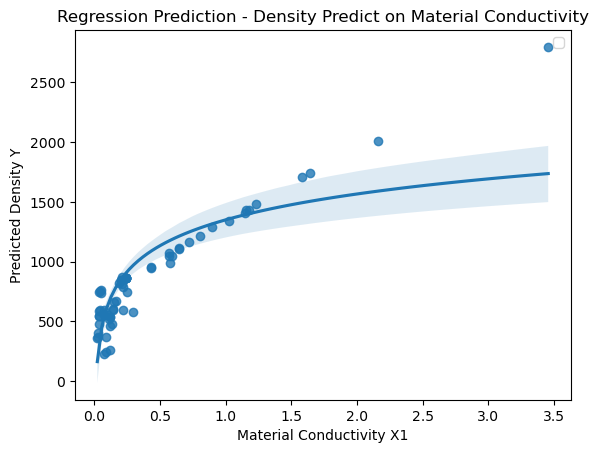

In [77]:
sns.regplot(data=materialData_ii_imputed, y=reg.predict(X_test), x= X_test[:,0], logx=True) #predicted density in relation to conductivity

# Adding titles and labels
plt.title('Regression Prediction - Density Predict on Material Conductivity')
plt.xlabel('Material Conductivity X1')
plt.ylabel('Predicted Density Y')
plt.legend()

# Display the plot
#plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


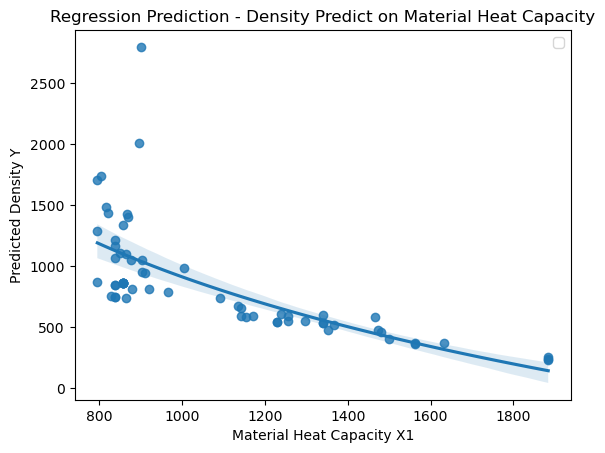

In [78]:
sns.regplot(data=materialData_ii_imputed, y=reg.predict(X_test), x= X_test[:,1], logx=True) #predicted density in relation to heat capacity

# Adding titles and labels
plt.title('Regression Prediction - Density Predict on Material Heat Capacity')
plt.xlabel('Material Heat Capacity X1')
plt.ylabel('Predicted Density Y')
plt.legend()


## Ridge Regression

alphas=[0.001,0.1,1,10,1000] are the possible choices the model searches to fit to the data input. it returns the best possible fit

In [79]:
from sklearn.linear_model import RidgeCV

rid = RidgeCV(
    alphas=[0.001,0.1,1,10,1000]
)

rid.fit(X_train, Y_train)
print(rid.alphas)

[0.001, 0.1, 1, 10, 1000]


In [80]:
# Fit the RidgeCV model
rid = RidgeCV(alphas=[0.001, 0.1, 1, 10, 1000])
rid.fit(X_train, Y_train)

# Print the best alpha value
print(f'Best alpha: {rid.alpha_}')

# Print the coefficients and intercept (similar to LinearRegression)
print('Ridge coefficients:', rid.coef_)
print('Ridge intercept:', rid.intercept_)

# Predict using the ridge regression model
predicted_Y_for_X_test_ridge = rid.predict(X_test)
print(predicted_Y_for_X_test_ridge)

# Save the predicted values to a CSV file
pd.DataFrame(predicted_Y_for_X_test_ridge).to_csv("Y_test_ridge.csv", index=False)

Best alpha: 10.0
Ridge coefficients: [[547.99835255  -0.55442939]]
Ridge intercept: [1221.66595828]
[[1310.27710016]
 [ 611.16204304]
 [ 367.12946702]
 [ 681.86075061]
 [1269.87473973]
 [ 602.04231511]
 [2616.47199229]
 [ 768.45191872]
 [ 407.21740278]
 [ 980.20461225]
 [ 559.4700677 ]
 [ 803.81677022]
 [ 559.67319884]
 [ 543.56240761]
 [ 243.68135031]
 [ 876.44752779]
 [ 836.78140241]
 [1046.82608774]
 [1044.73514223]
 [ 867.88542857]
 [ 876.44752779]
 [ 543.56240761]
 [1908.47134812]
 [ 957.00368919]
 [1442.48091479]
 [1199.31483219]
 [ 671.60162511]
 [1096.72715523]
 [ 826.47851692]
 [ 463.98899676]
 [ 777.92601901]
 [ 610.97896414]
 [ 526.26913262]
 [ 790.22763677]
 [ 559.4700677 ]
 [ 750.42483013]
 [ 876.44752779]
 [1069.11042362]
 [ 614.32850245]
 [ 876.44752779]
 [ 227.59124188]
 [1648.65120101]
 [1151.96777453]
 [ 476.22859431]
 [ 867.88542857]
 [ 951.71139795]
 [ 876.44752779]
 [1397.75607429]
 [ 489.57635562]
 [ 572.12165556]
 [ 780.2933719 ]
 [ 366.06344118]
 [1388.46854897]

## Kernel Regression

In [81]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(
    alpha=[0.001,0.1,1,10,1000]
)

krr.fit(X_train, Y_train)


#krr = KernelRidge(alpha=1.0)
#krr.fit(X, y)
#KernelRidge(alpha=1.0)

KernelRidge(alpha=[0.001, 0.1, 1, 10, 1000])

In [82]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(
    alpha=[0.001,0.1,1,10,1000]
)

krr.fit(X_train, Y_train)

# Kernel Ridge does not have the attributes coef_ and intercept_. This is because KernelRidge is a kernelized version of ridge regression, which means it doesn't operate in the original feature space but in a higher-dimensional space defined by a kernel function.

# Predict using the ridge regression model
predicted_Y_for_X_test_kernel_ridge = krr.predict(X_test)
print(predicted_Y_for_X_test_kernel_ridge)

# Save the predicted values to a CSV file
pd.DataFrame(predicted_Y_for_X_test_kernel_ridge).to_csv("Y_test_kernel.csv", index=False)

[[1144.44921875]
 [ 549.23925781]
 [ 676.30371094]
 [ 604.08691406]
 [1015.63842773]
 [ 514.59130859]
 [3012.49780273]
 [ 402.1862793 ]
 [ 655.14648438]
 [ 862.57397461]
 [ 545.27832031]
 [ 572.42260742]
 [ 627.44042969]
 [ 654.96875   ]
 [ 887.13037109]
 [ 542.58642578]
 [ 513.40454102]
 [ 803.41137695]
 [ 830.46166992]
 [ 506.72045898]
 [ 542.58642578]
 [ 654.96875   ]
 [2023.49023438]
 [ 710.49560547]
 [1279.80932617]
 [ 967.47167969]
 [ 598.31298828]
 [ 858.80566406]
 [ 549.01000977]
 [ 712.10107422]
 [ 381.65673828]
 [ 512.03686523]
 [ 663.88232422]
 [ 389.27197266]
 [ 545.27832031]
 [ 646.98046875]
 [ 542.58642578]
 [ 786.46044922]
 [ 631.69384766]
 [ 542.58642578]
 [ 864.76025391]
 [1542.21508789]
 [ 901.65136719]
 [ 721.4609375 ]
 [ 506.72045898]
 [ 711.12426758]
 [ 542.58642578]
 [1223.87304688]
 [ 595.89599609]
 [ 844.45263672]
 [ 384.94750977]
 [ 757.70117188]
 [1264.88427734]
 [ 542.58642578]
 [ 849.40039062]
 [1589.44946289]
 [ 637.57470703]
 [ 681.23681641]
 [ 729.5698242

## Model Validation

Evaluation Criteria:
Root Mean Squared Error (RMSE),
prediction accuracy PA, 
residuals means 
residual standard deviations 

In [114]:
#L1 Lasso regression
reg

# Evaluate the model on the test data
reg_test_score = reg.score(X_test, Y_test)
print("Linear R^2 score:", reg_test_score)

Linear R^2 score: 0.6186233925245348


In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

reg_mse = mean_squared_error(Y_test, reg.predict(X_test))
reg_mae = mean_absolute_error(Y_test, reg.predict(X_test))

print("Mean Squared Error:", reg_mse)
print("Mean Absolute Error:", reg_mae)

Mean Squared Error: 194233.53258406717
Mean Absolute Error: 339.0597991339404


In [116]:
#L2 Regularisation 
rid

# Evaluate the model on the test data
rid_test_score = rid.score(X_test, Y_test)
print("Ridge R^2 score:", rid_test_score)

Ridge R^2 score: 0.5992078207645564


In [117]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rid_mse = mean_squared_error(Y_test, rid.predict(X_test))
rid_mae = mean_absolute_error(Y_test, rid.predict(X_test))

print("Mean Squared Error:", rid_mse)
print("Mean Absolute Error:", rid_mae)

Mean Squared Error: 204121.80317057046
Mean Absolute Error: 351.7269554346278


In [118]:
#Kernel
krr

krr_test_score = krr.score(X_test, Y_test)
print("Kernel R^2 score:", krr_test_score)

Kernel R^2 score: 0.42735535265479774


In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

krr_mse = mean_squared_error(Y_test, krr.predict(X_test))
krr_mae = mean_absolute_error(Y_test, krr.predict(X_test))

print("Mean Squared Error:", krr_mse)
print("Mean Absolute Error:", krr_mae)

Mean Squared Error: 291645.5560960735
Mean Absolute Error: 440.0171417206562


In [128]:
modelevalu = ("Linear R^2 score:", reg_test_score, "LIN_MSE:", reg_mse, "LIN_MAE:", reg_mae,
              "Ridge R^2 score:", rid_test_score, "Mean Squared Error:", rid_mse, "Mean Absolute Error:", rid_mae,
              "Kernel R^2 score:", krr_test_score, "Mean Squared Error:", krr_mse,"Mean Absolute Error:", krr_mae)
print(modelevalu)

('Linear R^2 score:', 0.6186233925245348, 'LIN_MSE:', 194233.53258406717, 'LIN_MAE:', 339.0597991339404, 'Ridge R^2 score:', 0.5992078207645564, 'Mean Squared Error:', 204121.80317057046, 'Mean Absolute Error:', 351.7269554346278, 'Kernel R^2 score:', 0.42735535265479774, 'Mean Squared Error:', 291645.5560960735, 'Mean Absolute Error:', 440.0171417206562)


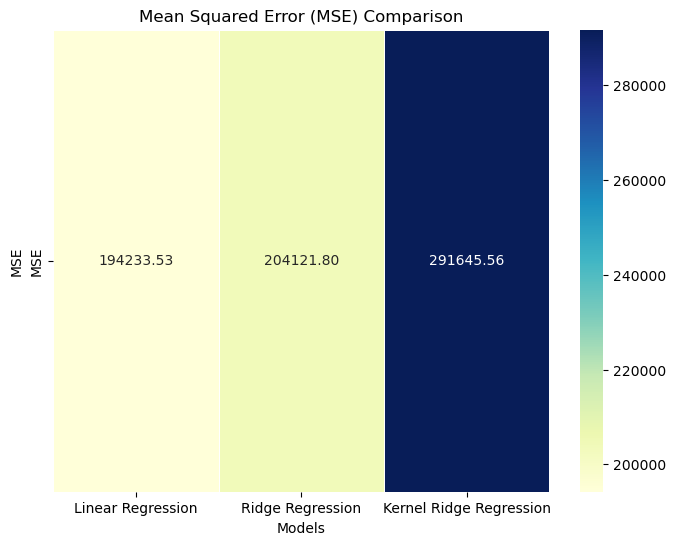

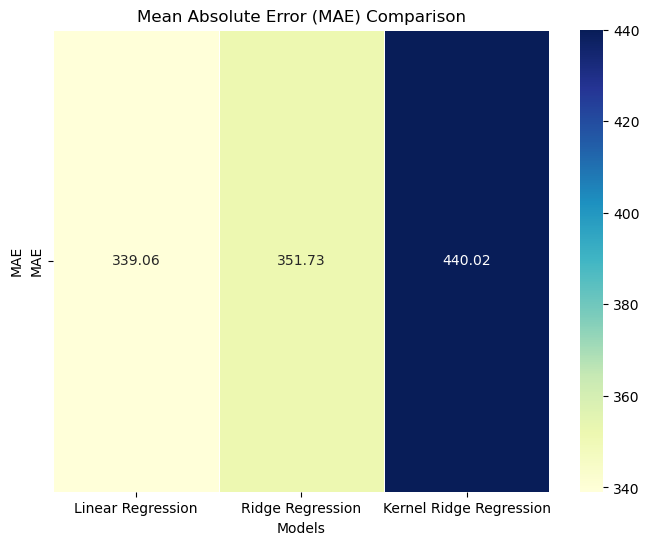

In [89]:
# Labels for the models
models = ['Linear Regression', 'Ridge Regression', 'Kernel Ridge Regression']
mse_values = [reg_mse, rid_mse, krr_mse]
mae_values = [reg_mae, rid_mae, krr_mae]

# Prepare the data for the heatmap
df_mse = pd.DataFrame(mse_values, index=models, columns=['MSE'])
df_mae = pd.DataFrame(mae_values, index=models, columns=['MAE'])


# Plotting the MSE comparison
plt.figure(figsize=(8, 6))
#plt.bar(models, mse_values, color=['blue', 'grey', 'red'])
sns.heatmap(df_mse.T, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE')
#plt.ylim(0, max(mse_values) + 1)  # Adjust y-axis for better visualization
plt.show()

# Plotting the MAE comparison
plt.figure(figsize=(8, 6))
#plt.bar(models, mae_values, color=['blue', 'grey', 'red'])
sns.heatmap(df_mae.T, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('Models')
plt.ylabel('MAE')
#plt.ylim(0, max(mae_values) + 1)  # Adjust y-axis for better visualization
plt.show()